# SEResNet for CIFAR-10

This notebook could fully reproduce the 

## Imports and Configurations

In [1]:
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.amp import autocast, GradScaler
from torchinfo import summary

from tqdm import tqdm

### 1) Model Definition and Utility Functions

In [2]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        mid_channels = channels // reduction
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # Two fully-connected layers (implemented as 1x1 conv for convenience)
        self.fc1 = nn.Conv2d(channels, mid_channels, kernel_size=1, bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(mid_channels, channels, kernel_size=1, bias=True)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        w = self.avg_pool(x)
        w = self.fc1(w)
        w = self.relu(w)
        w = self.fc2(w)
        w = self.sigmoid(w)
        return x * w  # scale the input features by the learned weights

# Basic Residual Block (for CIFAR-10 ResNet) with SE attention
class BasicBlock(nn.Module):
    expansion = 1  # expansion factor for output channels (1 for BasicBlock)
    def __init__(self, in_channels, out_channels, stride=1, use_se=False, norm_layer=nn.BatchNorm2d):
        super(BasicBlock, self).__init__()
        self.use_se = use_se
        # First 3x3 convolution (with stride, to downsample if needed)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = norm_layer(out_channels)
        # Second 3x3 convolution
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = norm_layer(out_channels)
        # Shortcut (identity or 1x1 conv if shape mismatch)
        if stride != 1 or in_channels != out_channels * BasicBlock.expansion:
            # Use 1x1 conv to match dimensions (for downsampling or channel increase)
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1,
                          stride=stride, bias=False),
                norm_layer(out_channels * BasicBlock.expansion)
            )
        else:
            self.shortcut = nn.Identity()
        # Squeeze-and-Excitation module (if use_se is True)
        self.se = SEBlock(out_channels * BasicBlock.expansion) if use_se else nn.Identity()
        # Activation (ReLU) - we will apply after each BN, and after adding shortcut
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)                 # SE attention (if no SE, this is identity)
        out += self.shortcut(x)            # add skip connection
        out = self.relu(out)
        return out

# Modified ResNet model for CIFAR-10
class ModifiedResNet(nn.Module):
    def __init__(self, num_blocks=[4,4,3], base_channels=64, num_classes=10, use_se=True, norm_layer=nn.BatchNorm2d):
        """
        num_blocks: list of number of residual blocks in each stage.
        base_channels: number of channels in first stage (will double each stage).
        use_se: whether to include SE attention in blocks.
        norm_layer: normalization layer to use (default BatchNorm2d).
        """
        super(ModifiedResNet, self).__init__()
        self.in_channels = base_channels
        self.use_se = use_se
        # Initial conv layer (3x3, same padding)
        self.conv1 = nn.Conv2d(3, base_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1  = norm_layer(base_channels)
        self.relu = nn.ReLU(inplace=True)
        # Build residual stages
        self.layers = nn.Sequential()  # will hold all residual blocks
        channels = base_channels
        for i, blocks in enumerate(num_blocks):
            # For each stage i:
            # Set stride=2 for stages beyond the first to downsample spatially.
            stride = 1 if i == 0 else 2
            # First block of this stage (may downsample and/or increase channels)
            layer_blocks = []
            layer_blocks.append(BasicBlock(self.in_channels, channels, stride=stride,
                                           use_se=self.use_se, norm_layer=norm_layer))
            self.in_channels = channels * BasicBlock.expansion  # update current channels
            # Remaining blocks of this stage (stride=1, same channel count)
            for j in range(1, blocks):
                layer_blocks.append(BasicBlock(self.in_channels, channels, stride=1,
                                               use_se=self.use_se, norm_layer=norm_layer))
                # in_channels remains the same within a stage for BasicBlock
            # Append this stage's blocks to the Sequential
            self.layers.extend(layer_blocks)
            # Double the channel count for next stage
            channels *= 2
        # Global average pool and linear classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(self.in_channels, num_classes)

    def forward(self, x):
        # Initial conv + BN + ReLU
        out = self.relu(self.bn1(self.conv1(x)))
        # Residual blocks
        out = self.layers(out)
        # Global pooling and output
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)   # flatten
        out = self.fc(out)
        return out

# 2) MixUp / CutMix Utilities

In [3]:
def mixup_data(x, y, alpha=1.0):
    """Compute MixUp data. Returns mixed inputs, pairs of targets, and lambda."""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Compute MixUp loss given the original criterion."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def rand_bbox(size, lam):
    """Generate a random bbox for CutMix."""
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform center
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    x1 = np.clip(cx - cut_w // 2, 0, W)
    y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W)
    y2 = np.clip(cy + cut_h // 2, 0, H)
    return x1, y1, x2, y2


def cutmix_data(x, y, alpha=1.0):
    """Compute CutMix data. Returns cut-mixed inputs, pairs of targets, and lam."""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    x1, y1 = x, y
    x2, y2 = x[index, :], y[index]

    # random bbox
    x1_coord, y1_coord, x2_coord, y2_coord = rand_bbox(x.size(), lam)

    # replace
    x1[:, :, x1_coord:x2_coord, y1_coord:y2_coord] = \
        x2[:, :, x1_coord:x2_coord, y1_coord:y2_coord]

    # adjust lambda to match the exact area of the cut region
    cut_area = (x2_coord - x1_coord) * (y2_coord - y1_coord)
    lam = 1.0 - cut_area / (x.size(-1) * x.size(-2))

    return x1, y1, y2, lam


def cutmix_criterion(criterion, pred, y_a, y_b, lam):
    """Compute CutMix loss given the original criterion."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

### 3) Data Loading

In [4]:
def load_cifar10_data(batch_size=1024):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(transforms.autoaugment.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616)),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616)),
    ])
    
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data',
        train=False,
        download=True,
        transform=transform_test
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=12,
        pin_memory=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=12,
        pin_memory=True
    )

    return train_loader, test_loader

### 4) Training and Evaluation Logic

In [5]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler,
                    mix_prob=1.0, mixup_alpha=1.0, cutmix_alpha=1.0):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in tqdm(train_loader, desc='Training', leave=False):
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        
        with autocast(device_type='cuda'):
            # Decide whether to apply MixUp, CutMix, or no mixing
            if random.random() < mix_prob:
                # 50/50 random choice between MixUp and CutMix
                if random.random() < 0.5:
                    # MixUp
                    mixed_images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=mixup_alpha)
                    logits = model(mixed_images)
                    loss = mixup_criterion(criterion, logits, targets_a, targets_b, lam)
                    _, preds = logits.max(dim=1)
                    # Hard to define 'correct' for mixed samples, so we'll skip accuracy tracking or do approximate
                else:
                    # CutMix
                    mixed_images, targets_a, targets_b, lam = cutmix_data(images, labels, alpha=cutmix_alpha)
                    logits = model(mixed_images)
                    loss = cutmix_criterion(criterion, logits, targets_a, targets_b, lam)
                    _, preds = logits.max(dim=1)
            else:
                # No mixing
                logits = model(images)
                loss = criterion(logits, labels)
                _, preds = logits.max(dim=1)
                total_correct += preds.eq(labels).sum().item()
            
            total_loss += loss.item() * images.size(0)
            total_samples += images.size(0)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    avg_loss = total_loss / total_samples
    accuracy = 100.0 * total_correct / total_samples
    return avg_loss, accuracy

def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad(), autocast(device_type='cuda'):
        for images, labels in tqdm(test_loader, desc='Evaluating', leave=False):
            images, labels = images.cuda(), labels.cuda()
            logits = model(images)
            loss = criterion(logits, labels)
            _, preds = logits.max(dim=1)
            total_correct += preds.eq(labels).sum().item()
            total_loss += loss.item() * images.size(0)
            total_samples += labels.size(0)
    
    avg_loss = total_loss / total_samples
    accuracy = 100.0 * total_correct / total_samples
    return avg_loss, accuracy

### 5) Main Experiment / Training Loop

In [7]:
def main_experiment(
    num_epochs=1000,
    batch_size=1024,
    initial_lr=0.1,
    mix_prob=1.0,
    mixup_alpha=1.0,
    cutmix_alpha=1.0
):
    # Data
    train_loader, test_loader = load_cifar10_data(batch_size=batch_size)
    
    # Model
    model = ModifiedResNet(
        num_blocks=[4,4,3],
        base_channels=64,
        num_classes=10,
        use_se=True
    ).cuda()
    
    summary(model, input_size=(1, 3, 32, 32))
    
    # Optimizer
    optimizer = optim.SGD(
        model.parameters(),
        lr=initial_lr,
        momentum=0.9,
        weight_decay=5e-4
    )
    
    # LR Scheduler
    def lr_lambda(epoch):
        warmup_epochs = 10
        total_epochs = num_epochs
        if epoch < warmup_epochs:
            return float(epoch + 1) / warmup_epochs
        else:
            return 0.5 * (
                1.0 + math.cos(
                    math.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
                )
            )
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    # AMP Gradient Scaler
    scaler = GradScaler(device='cuda')
    
    # Loss
    criterion = nn.CrossEntropyLoss(label_smoothing=0.0)

    # Visualization Purposes
    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []
    
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'\nEpoch [{epoch+1}/{num_epochs}]')
        
        # Train
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler,
            mix_prob=mix_prob, mixup_alpha=mixup_alpha, cutmix_alpha=cutmix_alpha
        )
        
        # Step LR
        scheduler.step()
        
        # Evaluate
        test_loss, test_acc = evaluate(model, test_loader, criterion)

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)
        
        # Print metrics for each epoch
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Test Loss:  {test_loss:.4f}, Test Acc:  {test_acc:.2f}%')
        
        # Save best
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saving model with Test Acc: {best_acc:.2f}%')
    
    print(f'\nTraining complete. Best Test Accuracy: {best_acc:.2f}%')
    return best_acc

### 6) Running Experiments

In [ ]:
exp_configs = [
        {'num_epochs': 1000, 'batch_size': 1024, 'initial_lr': 0.1, 
         'mix_prob': 1.0, 'mixup_alpha': 1.0, 'cutmix_alpha': 1.0},
        # Add more dicts if for different configurations
    ]
    
for cfg in exp_configs:
    print(f'Running Experiment: {cfg}')
    best_acc = main_experiment(**cfg)
    print(f'Finished Experiment: Best Accuracy = {best_acc:.2f}%')

Running Experiment: {'num_epochs': 1000, 'batch_size': 1024, 'initial_lr': 0.1, 'mix_prob': 1.0, 'mixup_alpha': 1.0, 'cutmix_alpha': 1.0}

Epoch [1/1000]


Train Loss: 2.1976, Train Acc: 0.00%
Test Loss:  1.9533, Test Acc:  27.20%
Saving model with Test Acc: 27.20%

Epoch [2/1000]


Train Loss: 2.0360, Train Acc: 0.00%
Test Loss:  1.5702, Test Acc:  42.01%
Saving model with Test Acc: 42.01%

Epoch [3/1000]


Train Loss: 1.9510, Train Acc: 0.00%
Test Loss:  1.3003, Test Acc:  52.73%
Saving model with Test Acc: 52.73%

Epoch [4/1000]


Train Loss: 1.8176, Train Acc: 0.00%
Test Loss:  1.3182, Test Acc:  55.68%
Saving model with Test Acc: 55.68%

Epoch [5/1000]


Train Loss: 1.7330, Train Acc: 0.00%
Test Loss:  1.5277, Test Acc:  47.10%

Epoch [6/1000]


Train Loss: 1.6817, Train Acc: 0.00%
Test Loss:  1.1474, Test Acc:  60.53%
Saving model with Test Acc: 60.53%

Epoch [7/1000]


Train Loss: 1.6801, Train Acc: 0.00%
Test Loss:  1.3479, Test Acc:  51.41%

Epoch [8/1000]


Train Loss: 1.6594, Train Acc: 0.00%
Test Loss:  1.2162, Test Acc:  57.07%

Epoch [9/1000]


Train Loss: 1.5228, Train Acc: 0.00%
Test Loss:  1.0398, Test Acc:  65.31%
Saving model with Test Acc: 65.31%

Epoch [10/1000]


Train Loss: 1.6218, Train Acc: 0.00%
Test Loss:  1.0103, Test Acc:  65.66%
Saving model with Test Acc: 65.66%

Epoch [11/1000]


Train Loss: 1.5777, Train Acc: 0.00%
Test Loss:  0.9524, Test Acc:  68.44%
Saving model with Test Acc: 68.44%

Epoch [12/1000]


Train Loss: 1.5072, Train Acc: 0.00%
Test Loss:  0.7382, Test Acc:  75.59%
Saving model with Test Acc: 75.59%

Epoch [13/1000]


Train Loss: 1.4959, Train Acc: 0.00%
Test Loss:  0.8521, Test Acc:  78.28%
Saving model with Test Acc: 78.28%

Epoch [14/1000]


Train Loss: 1.3821, Train Acc: 0.00%
Test Loss:  1.0345, Test Acc:  64.01%

Epoch [15/1000]


Train Loss: 1.4257, Train Acc: 0.00%
Test Loss:  0.7160, Test Acc:  77.27%

Epoch [16/1000]


Train Loss: 1.3500, Train Acc: 0.00%
Test Loss:  0.7304, Test Acc:  78.61%
Saving model with Test Acc: 78.61%

Epoch [17/1000]


Train Loss: 1.4335, Train Acc: 0.00%
Test Loss:  0.8291, Test Acc:  76.91%

Epoch [18/1000]


Train Loss: 1.3605, Train Acc: 0.00%
Test Loss:  0.7520, Test Acc:  76.76%

Epoch [19/1000]


Train Loss: 1.4174, Train Acc: 0.00%
Test Loss:  0.6638, Test Acc:  79.03%
Saving model with Test Acc: 79.03%

Epoch [20/1000]


Train Loss: 1.3658, Train Acc: 0.00%
Test Loss:  0.8042, Test Acc:  73.61%

Epoch [21/1000]


Train Loss: 1.3299, Train Acc: 0.00%
Test Loss:  0.9167, Test Acc:  73.67%

Epoch [22/1000]


Train Loss: 1.4241, Train Acc: 0.00%
Test Loss:  0.7699, Test Acc:  81.00%
Saving model with Test Acc: 81.00%

Epoch [23/1000]


Train Loss: 1.3269, Train Acc: 0.00%
Test Loss:  0.5257, Test Acc:  83.63%
Saving model with Test Acc: 83.63%

Epoch [24/1000]


Train Loss: 1.3210, Train Acc: 0.00%
Test Loss:  0.6878, Test Acc:  80.21%

Epoch [25/1000]


Train Loss: 1.3153, Train Acc: 0.00%
Test Loss:  0.8204, Test Acc:  76.09%

Epoch [26/1000]


Train Loss: 1.4122, Train Acc: 0.00%
Test Loss:  0.6356, Test Acc:  82.43%

Epoch [27/1000]


Train Loss: 1.3689, Train Acc: 0.00%
Test Loss:  0.7332, Test Acc:  76.93%

Epoch [28/1000]


Train Loss: 1.3326, Train Acc: 0.00%
Test Loss:  0.5243, Test Acc:  83.71%
Saving model with Test Acc: 83.71%

Epoch [29/1000]


Train Loss: 1.3084, Train Acc: 0.00%
Test Loss:  0.5837, Test Acc:  83.25%

Epoch [30/1000]


Train Loss: 1.3270, Train Acc: 0.00%
Test Loss:  0.6076, Test Acc:  83.13%

Epoch [31/1000]


Train Loss: 1.3102, Train Acc: 0.00%
Test Loss:  0.7546, Test Acc:  78.91%

Epoch [32/1000]


Train Loss: 1.3214, Train Acc: 0.00%
Test Loss:  0.6333, Test Acc:  83.36%

Epoch [33/1000]


Train Loss: 1.3371, Train Acc: 0.00%
Test Loss:  0.5543, Test Acc:  86.59%
Saving model with Test Acc: 86.59%

Epoch [34/1000]


Train Loss: 1.2425, Train Acc: 0.00%
Test Loss:  0.5359, Test Acc:  83.08%

Epoch [35/1000]


Train Loss: 1.2693, Train Acc: 0.00%
Test Loss:  0.5647, Test Acc:  84.57%

Epoch [36/1000]


Train Loss: 1.2339, Train Acc: 0.00%
Test Loss:  0.7084, Test Acc:  79.63%

Epoch [37/1000]


Train Loss: 1.2701, Train Acc: 0.00%
Test Loss:  0.5343, Test Acc:  86.26%

Epoch [38/1000]


Train Loss: 1.2855, Train Acc: 0.00%
Test Loss:  0.5534, Test Acc:  85.76%

Epoch [39/1000]


Train Loss: 1.2897, Train Acc: 0.00%
Test Loss:  0.4109, Test Acc:  89.09%
Saving model with Test Acc: 89.09%

Epoch [40/1000]


Train Loss: 1.2525, Train Acc: 0.00%
Test Loss:  0.5846, Test Acc:  83.88%

Epoch [41/1000]


Train Loss: 1.2720, Train Acc: 0.00%
Test Loss:  0.5801, Test Acc:  83.42%

Epoch [42/1000]


Train Loss: 1.2784, Train Acc: 0.00%
Test Loss:  0.5495, Test Acc:  88.50%

Epoch [43/1000]


Train Loss: 1.2171, Train Acc: 0.00%
Test Loss:  0.5740, Test Acc:  83.15%

Epoch [44/1000]


Train Loss: 1.1382, Train Acc: 0.00%
Test Loss:  0.4416, Test Acc:  88.33%

Epoch [45/1000]


Train Loss: 1.1951, Train Acc: 0.00%
Test Loss:  0.5500, Test Acc:  84.99%

Epoch [46/1000]


Train Loss: 1.2097, Train Acc: 0.00%
Test Loss:  0.5044, Test Acc:  86.79%

Epoch [47/1000]


Train Loss: 1.1769, Train Acc: 0.00%
Test Loss:  0.4537, Test Acc:  88.43%

Epoch [48/1000]


Train Loss: 1.1705, Train Acc: 0.00%
Test Loss:  0.5751, Test Acc:  84.28%

Epoch [49/1000]


Train Loss: 1.2139, Train Acc: 0.00%
Test Loss:  0.4225, Test Acc:  89.92%
Saving model with Test Acc: 89.92%

Epoch [50/1000]


Train Loss: 1.0468, Train Acc: 0.00%
Test Loss:  0.4311, Test Acc:  88.54%

Epoch [51/1000]


Train Loss: 1.2729, Train Acc: 0.00%
Test Loss:  0.5005, Test Acc:  88.50%

Epoch [52/1000]


Train Loss: 1.2389, Train Acc: 0.00%
Test Loss:  0.4848, Test Acc:  89.37%

Epoch [53/1000]


Train Loss: 1.1160, Train Acc: 0.00%
Test Loss:  0.4269, Test Acc:  87.80%

Epoch [54/1000]


Train Loss: 1.1995, Train Acc: 0.00%
Test Loss:  0.4342, Test Acc:  90.32%
Saving model with Test Acc: 90.32%

Epoch [55/1000]


Train Loss: 1.1588, Train Acc: 0.00%
Test Loss:  0.6144, Test Acc:  89.98%

Epoch [56/1000]


Train Loss: 1.1499, Train Acc: 0.00%
Test Loss:  0.3442, Test Acc:  89.81%

Epoch [57/1000]


Train Loss: 1.2335, Train Acc: 0.00%
Test Loss:  0.4162, Test Acc:  88.71%

Epoch [58/1000]


Train Loss: 1.1988, Train Acc: 0.00%
Test Loss:  0.3965, Test Acc:  90.43%
Saving model with Test Acc: 90.43%

Epoch [59/1000]


Train Loss: 1.2623, Train Acc: 0.00%
Test Loss:  0.4309, Test Acc:  90.82%
Saving model with Test Acc: 90.82%

Epoch [60/1000]


Train Loss: 1.2407, Train Acc: 0.00%
Test Loss:  0.4745, Test Acc:  90.92%
Saving model with Test Acc: 90.92%

Epoch [61/1000]


Train Loss: 1.2192, Train Acc: 0.00%
Test Loss:  0.4940, Test Acc:  88.03%

Epoch [62/1000]


Train Loss: 1.1091, Train Acc: 0.00%
Test Loss:  0.4426, Test Acc:  89.34%

Epoch [63/1000]


Train Loss: 1.1995, Train Acc: 0.00%
Test Loss:  0.5098, Test Acc:  89.60%

Epoch [64/1000]


Train Loss: 1.1223, Train Acc: 0.00%
Test Loss:  0.4516, Test Acc:  89.48%

Epoch [65/1000]


Train Loss: 1.2501, Train Acc: 0.00%
Test Loss:  0.4211, Test Acc:  90.67%

Epoch [66/1000]


Train Loss: 1.1485, Train Acc: 0.00%
Test Loss:  0.4599, Test Acc:  89.15%

Epoch [67/1000]


Train Loss: 1.2065, Train Acc: 0.00%
Test Loss:  0.4786, Test Acc:  88.77%

Epoch [68/1000]


Train Loss: 1.0924, Train Acc: 0.00%
Test Loss:  0.5690, Test Acc:  84.48%

Epoch [69/1000]


Train Loss: 1.1485, Train Acc: 0.00%
Test Loss:  0.4560, Test Acc:  87.06%

Epoch [70/1000]


Train Loss: 1.1298, Train Acc: 0.00%
Test Loss:  0.4568, Test Acc:  90.42%

Epoch [71/1000]


Train Loss: 1.1590, Train Acc: 0.00%
Test Loss:  0.4473, Test Acc:  90.23%

Epoch [72/1000]


Train Loss: 1.1605, Train Acc: 0.00%
Test Loss:  0.4534, Test Acc:  87.29%

Epoch [73/1000]


Train Loss: 1.0844, Train Acc: 0.00%
Test Loss:  0.4173, Test Acc:  89.43%

Epoch [74/1000]


Train Loss: 1.1577, Train Acc: 0.00%
Test Loss:  0.3997, Test Acc:  89.82%

Epoch [75/1000]


Train Loss: 1.1953, Train Acc: 0.00%
Test Loss:  0.5150, Test Acc:  88.02%

Epoch [76/1000]


Train Loss: 1.1276, Train Acc: 0.00%
Test Loss:  0.4823, Test Acc:  88.13%

Epoch [77/1000]


Train Loss: 1.1682, Train Acc: 0.00%
Test Loss:  0.4562, Test Acc:  90.07%

Epoch [78/1000]


Train Loss: 1.0754, Train Acc: 0.00%
Test Loss:  0.4057, Test Acc:  88.78%

Epoch [79/1000]


Train Loss: 1.1686, Train Acc: 0.00%
Test Loss:  0.5096, Test Acc:  87.53%

Epoch [80/1000]


Train Loss: 1.0983, Train Acc: 0.00%
Test Loss:  0.3441, Test Acc:  92.00%
Saving model with Test Acc: 92.00%

Epoch [81/1000]


Train Loss: 1.0755, Train Acc: 0.00%
Test Loss:  0.4262, Test Acc:  89.44%

Epoch [82/1000]


Train Loss: 1.1165, Train Acc: 0.00%
Test Loss:  0.3811, Test Acc:  88.74%

Epoch [83/1000]


Train Loss: 1.1474, Train Acc: 0.00%
Test Loss:  0.4072, Test Acc:  90.41%

Epoch [84/1000]


Train Loss: 1.1434, Train Acc: 0.00%
Test Loss:  0.4635, Test Acc:  89.99%

Epoch [85/1000]


Train Loss: 1.1183, Train Acc: 0.00%
Test Loss:  0.3713, Test Acc:  90.59%

Epoch [86/1000]


Train Loss: 1.1289, Train Acc: 0.00%
Test Loss:  0.4542, Test Acc:  89.99%

Epoch [87/1000]


Train Loss: 1.0974, Train Acc: 0.00%
Test Loss:  0.4073, Test Acc:  91.48%

Epoch [88/1000]


Train Loss: 1.0544, Train Acc: 0.00%
Test Loss:  0.3550, Test Acc:  90.51%

Epoch [89/1000]


Train Loss: 1.0996, Train Acc: 0.00%
Test Loss:  0.5168, Test Acc:  89.22%

Epoch [90/1000]


Train Loss: 1.0645, Train Acc: 0.00%
Test Loss:  0.4227, Test Acc:  89.02%

Epoch [91/1000]


Train Loss: 1.0892, Train Acc: 0.00%
Test Loss:  0.4216, Test Acc:  88.94%

Epoch [92/1000]


Train Loss: 1.1191, Train Acc: 0.00%
Test Loss:  0.3830, Test Acc:  90.01%

Epoch [93/1000]


Train Loss: 1.1247, Train Acc: 0.00%
Test Loss:  0.4211, Test Acc:  89.63%

Epoch [94/1000]


Train Loss: 1.0460, Train Acc: 0.00%
Test Loss:  0.3998, Test Acc:  90.04%

Epoch [95/1000]


Train Loss: 1.1474, Train Acc: 0.00%
Test Loss:  0.3582, Test Acc:  92.90%
Saving model with Test Acc: 92.90%

Epoch [96/1000]


Train Loss: 1.1370, Train Acc: 0.00%
Test Loss:  0.5457, Test Acc:  86.82%

Epoch [97/1000]


Train Loss: 1.0980, Train Acc: 0.00%
Test Loss:  0.4314, Test Acc:  90.97%

Epoch [98/1000]


Train Loss: 1.1118, Train Acc: 0.00%
Test Loss:  0.3708, Test Acc:  91.60%

Epoch [99/1000]


Train Loss: 1.0911, Train Acc: 0.00%
Test Loss:  0.3785, Test Acc:  90.40%

Epoch [100/1000]


Train Loss: 1.1017, Train Acc: 0.00%
Test Loss:  0.3920, Test Acc:  92.15%

Epoch [101/1000]


Train Loss: 1.0740, Train Acc: 0.00%
Test Loss:  0.4369, Test Acc:  91.31%

Epoch [102/1000]


Train Loss: 1.1685, Train Acc: 0.00%
Test Loss:  0.3755, Test Acc:  91.72%

Epoch [103/1000]


Train Loss: 1.2137, Train Acc: 0.00%
Test Loss:  0.4894, Test Acc:  89.29%

Epoch [104/1000]


Train Loss: 1.0895, Train Acc: 0.00%
Test Loss:  0.2846, Test Acc:  93.12%
Saving model with Test Acc: 93.12%

Epoch [105/1000]


Train Loss: 1.0932, Train Acc: 0.00%
Test Loss:  0.3604, Test Acc:  91.76%

Epoch [106/1000]


Train Loss: 1.0161, Train Acc: 0.00%
Test Loss:  0.4227, Test Acc:  90.91%

Epoch [107/1000]


Train Loss: 1.0631, Train Acc: 0.00%
Test Loss:  0.3620, Test Acc:  90.46%

Epoch [108/1000]


Train Loss: 1.1232, Train Acc: 0.00%
Test Loss:  0.4364, Test Acc:  89.55%

Epoch [109/1000]


Train Loss: 1.1342, Train Acc: 0.00%
Test Loss:  0.3818, Test Acc:  91.70%

Epoch [110/1000]


Train Loss: 1.1141, Train Acc: 0.00%
Test Loss:  0.4294, Test Acc:  90.69%

Epoch [111/1000]


Train Loss: 1.1154, Train Acc: 0.00%
Test Loss:  0.4225, Test Acc:  90.14%

Epoch [112/1000]


Train Loss: 1.0936, Train Acc: 0.00%
Test Loss:  0.3538, Test Acc:  91.99%

Epoch [113/1000]


Train Loss: 1.0596, Train Acc: 0.00%
Test Loss:  0.3271, Test Acc:  91.24%

Epoch [114/1000]


Train Loss: 1.1422, Train Acc: 0.00%
Test Loss:  0.4302, Test Acc:  90.81%

Epoch [115/1000]


Train Loss: 1.0530, Train Acc: 0.00%
Test Loss:  0.3577, Test Acc:  92.98%

Epoch [116/1000]


Train Loss: 0.9903, Train Acc: 0.00%
Test Loss:  0.3762, Test Acc:  91.42%

Epoch [117/1000]


Train Loss: 1.0688, Train Acc: 0.00%
Test Loss:  0.4494, Test Acc:  88.93%

Epoch [118/1000]


Train Loss: 1.1073, Train Acc: 0.00%
Test Loss:  0.4367, Test Acc:  90.67%

Epoch [119/1000]


Train Loss: 1.0688, Train Acc: 0.00%
Test Loss:  0.3205, Test Acc:  93.22%
Saving model with Test Acc: 93.22%

Epoch [120/1000]


Train Loss: 1.1395, Train Acc: 0.00%
Test Loss:  0.3547, Test Acc:  91.28%

Epoch [121/1000]


Train Loss: 1.0009, Train Acc: 0.00%
Test Loss:  0.4057, Test Acc:  91.40%

Epoch [122/1000]


Train Loss: 1.1685, Train Acc: 0.00%
Test Loss:  0.3555, Test Acc:  89.09%

Epoch [123/1000]


Train Loss: 1.1484, Train Acc: 0.00%
Test Loss:  0.4282, Test Acc:  91.59%

Epoch [124/1000]


Train Loss: 1.1106, Train Acc: 0.00%
Test Loss:  0.4147, Test Acc:  91.42%

Epoch [125/1000]


Train Loss: 1.1241, Train Acc: 0.00%
Test Loss:  0.3985, Test Acc:  89.01%

Epoch [126/1000]


Train Loss: 1.0457, Train Acc: 0.00%
Test Loss:  0.3684, Test Acc:  90.99%

Epoch [127/1000]


Train Loss: 1.0932, Train Acc: 0.00%
Test Loss:  0.3864, Test Acc:  90.16%

Epoch [128/1000]


Train Loss: 1.1227, Train Acc: 0.00%
Test Loss:  0.4160, Test Acc:  91.19%

Epoch [129/1000]


Train Loss: 1.1227, Train Acc: 0.00%
Test Loss:  0.6563, Test Acc:  85.14%

Epoch [130/1000]


Train Loss: 1.1263, Train Acc: 0.00%
Test Loss:  0.3637, Test Acc:  92.14%

Epoch [131/1000]


Train Loss: 1.0273, Train Acc: 0.00%
Test Loss:  0.3246, Test Acc:  92.19%

Epoch [132/1000]


Train Loss: 1.0318, Train Acc: 0.00%
Test Loss:  0.2926, Test Acc:  91.92%

Epoch [133/1000]


Train Loss: 1.0734, Train Acc: 0.00%
Test Loss:  0.3634, Test Acc:  91.22%

Epoch [134/1000]


Train Loss: 1.0564, Train Acc: 0.00%
Test Loss:  0.4172, Test Acc:  90.00%

Epoch [135/1000]


Train Loss: 1.0545, Train Acc: 0.00%
Test Loss:  0.3468, Test Acc:  91.79%

Epoch [136/1000]


Train Loss: 1.0405, Train Acc: 0.00%
Test Loss:  0.3408, Test Acc:  90.78%

Epoch [137/1000]


Train Loss: 1.0795, Train Acc: 0.00%
Test Loss:  0.3848, Test Acc:  91.20%

Epoch [138/1000]


Train Loss: 1.1006, Train Acc: 0.00%
Test Loss:  0.4653, Test Acc:  88.77%

Epoch [139/1000]


Train Loss: 1.0528, Train Acc: 0.00%
Test Loss:  0.4387, Test Acc:  88.61%

Epoch [140/1000]


Train Loss: 1.0614, Train Acc: 0.00%
Test Loss:  0.4231, Test Acc:  91.94%

Epoch [141/1000]


Train Loss: 1.1491, Train Acc: 0.00%
Test Loss:  0.3937, Test Acc:  90.60%

Epoch [142/1000]


Train Loss: 1.0276, Train Acc: 0.00%
Test Loss:  0.4118, Test Acc:  90.10%

Epoch [143/1000]


Train Loss: 1.0652, Train Acc: 0.00%
Test Loss:  0.4607, Test Acc:  89.56%

Epoch [144/1000]


Train Loss: 1.1546, Train Acc: 0.00%
Test Loss:  0.4501, Test Acc:  91.15%

Epoch [145/1000]


Train Loss: 1.1409, Train Acc: 0.00%
Test Loss:  0.3532, Test Acc:  93.17%

Epoch [146/1000]


Train Loss: 1.0970, Train Acc: 0.00%
Test Loss:  0.4889, Test Acc:  89.13%

Epoch [147/1000]


Train Loss: 1.0500, Train Acc: 0.00%
Test Loss:  0.3529, Test Acc:  92.32%

Epoch [148/1000]


Train Loss: 0.9996, Train Acc: 0.00%
Test Loss:  0.3384, Test Acc:  91.96%

Epoch [149/1000]


Train Loss: 0.9990, Train Acc: 0.00%
Test Loss:  0.4912, Test Acc:  86.68%

Epoch [150/1000]


Train Loss: 1.0325, Train Acc: 0.00%
Test Loss:  0.3680, Test Acc:  91.11%

Epoch [151/1000]


Train Loss: 1.0553, Train Acc: 0.00%
Test Loss:  0.4038, Test Acc:  91.94%

Epoch [152/1000]


Train Loss: 1.0766, Train Acc: 0.00%
Test Loss:  0.3791, Test Acc:  92.42%

Epoch [153/1000]


Train Loss: 1.1719, Train Acc: 0.00%
Test Loss:  0.4657, Test Acc:  90.63%

Epoch [154/1000]


Train Loss: 1.1442, Train Acc: 0.00%
Test Loss:  0.3961, Test Acc:  92.54%

Epoch [155/1000]


Train Loss: 1.1514, Train Acc: 0.00%
Test Loss:  0.4338, Test Acc:  91.28%

Epoch [156/1000]


Train Loss: 0.9924, Train Acc: 0.00%
Test Loss:  0.6126, Test Acc:  80.37%

Epoch [157/1000]


Train Loss: 1.0688, Train Acc: 0.00%
Test Loss:  0.3356, Test Acc:  92.71%

Epoch [158/1000]


Train Loss: 1.0833, Train Acc: 0.00%
Test Loss:  0.3565, Test Acc:  91.65%

Epoch [159/1000]


Train Loss: 1.0422, Train Acc: 0.00%
Test Loss:  0.3935, Test Acc:  90.46%

Epoch [160/1000]


Train Loss: 1.0447, Train Acc: 0.00%
Test Loss:  0.5371, Test Acc:  88.01%

Epoch [161/1000]


Train Loss: 0.9918, Train Acc: 0.00%
Test Loss:  0.5020, Test Acc:  86.20%

Epoch [162/1000]


Train Loss: 1.0973, Train Acc: 0.00%
Test Loss:  0.3890, Test Acc:  90.43%

Epoch [163/1000]


Train Loss: 1.0578, Train Acc: 0.00%
Test Loss:  0.4710, Test Acc:  88.68%

Epoch [164/1000]


Train Loss: 1.1616, Train Acc: 0.00%
Test Loss:  0.4237, Test Acc:  92.41%

Epoch [165/1000]


Train Loss: 1.0760, Train Acc: 0.00%
Test Loss:  0.3860, Test Acc:  92.35%

Epoch [166/1000]


Train Loss: 1.0373, Train Acc: 0.00%
Test Loss:  0.4001, Test Acc:  90.34%

Epoch [167/1000]


Train Loss: 1.1467, Train Acc: 0.00%
Test Loss:  0.3794, Test Acc:  92.33%

Epoch [168/1000]


Train Loss: 1.0489, Train Acc: 0.00%
Test Loss:  0.4627, Test Acc:  88.47%

Epoch [169/1000]


Train Loss: 1.0132, Train Acc: 0.00%
Test Loss:  0.4248, Test Acc:  92.97%

Epoch [170/1000]


Train Loss: 1.0810, Train Acc: 0.00%
Test Loss:  0.3658, Test Acc:  93.20%

Epoch [171/1000]


Train Loss: 1.0162, Train Acc: 0.00%
Test Loss:  0.3492, Test Acc:  93.08%

Epoch [172/1000]


Train Loss: 0.9782, Train Acc: 0.00%
Test Loss:  0.3907, Test Acc:  90.67%

Epoch [173/1000]


Train Loss: 1.0475, Train Acc: 0.00%
Test Loss:  0.5111, Test Acc:  89.20%

Epoch [174/1000]


Train Loss: 1.1606, Train Acc: 0.00%
Test Loss:  0.4173, Test Acc:  93.15%

Epoch [175/1000]


Train Loss: 1.0973, Train Acc: 0.00%
Test Loss:  0.4544, Test Acc:  92.06%

Epoch [176/1000]


Train Loss: 1.0022, Train Acc: 0.00%
Test Loss:  0.3774, Test Acc:  92.93%

Epoch [177/1000]


Train Loss: 0.9605, Train Acc: 0.00%
Test Loss:  0.3514, Test Acc:  91.08%

Epoch [178/1000]


Train Loss: 1.0911, Train Acc: 0.00%
Test Loss:  0.3456, Test Acc:  91.98%

Epoch [179/1000]


Train Loss: 1.1109, Train Acc: 0.00%
Test Loss:  0.3685, Test Acc:  93.12%

Epoch [180/1000]


Train Loss: 1.0421, Train Acc: 0.00%
Test Loss:  0.3857, Test Acc:  92.23%

Epoch [181/1000]


Train Loss: 1.0706, Train Acc: 0.00%
Test Loss:  0.3372, Test Acc:  92.08%

Epoch [182/1000]


Train Loss: 1.0793, Train Acc: 0.00%
Test Loss:  0.4305, Test Acc:  91.10%

Epoch [183/1000]


Train Loss: 1.0781, Train Acc: 0.00%
Test Loss:  0.3843, Test Acc:  92.50%

Epoch [184/1000]


Train Loss: 1.0761, Train Acc: 0.00%
Test Loss:  0.3809, Test Acc:  93.48%
Saving model with Test Acc: 93.48%

Epoch [185/1000]


Train Loss: 1.0803, Train Acc: 0.00%
Test Loss:  0.4041, Test Acc:  91.56%

Epoch [186/1000]


Train Loss: 1.0774, Train Acc: 0.00%
Test Loss:  0.4085, Test Acc:  92.04%

Epoch [187/1000]


Train Loss: 1.0390, Train Acc: 0.00%
Test Loss:  0.3710, Test Acc:  92.03%

Epoch [188/1000]


Train Loss: 0.9846, Train Acc: 0.00%
Test Loss:  0.4275, Test Acc:  90.87%

Epoch [189/1000]


Train Loss: 1.0385, Train Acc: 0.00%
Test Loss:  0.3498, Test Acc:  92.61%

Epoch [190/1000]


Train Loss: 1.0637, Train Acc: 0.00%
Test Loss:  0.4228, Test Acc:  90.88%

Epoch [191/1000]


Train Loss: 1.0201, Train Acc: 0.00%
Test Loss:  0.4749, Test Acc:  91.12%

Epoch [192/1000]


Train Loss: 1.0684, Train Acc: 0.00%
Test Loss:  0.3625, Test Acc:  92.78%

Epoch [193/1000]


Train Loss: 1.0245, Train Acc: 0.00%
Test Loss:  0.3322, Test Acc:  91.90%

Epoch [194/1000]


Train Loss: 1.0229, Train Acc: 0.00%
Test Loss:  0.3554, Test Acc:  92.53%

Epoch [195/1000]


Train Loss: 1.0206, Train Acc: 0.00%
Test Loss:  0.3821, Test Acc:  91.65%

Epoch [196/1000]


Train Loss: 1.0476, Train Acc: 0.00%
Test Loss:  0.3540, Test Acc:  92.82%

Epoch [197/1000]


Train Loss: 1.0347, Train Acc: 0.00%
Test Loss:  0.4044, Test Acc:  90.48%

Epoch [198/1000]


Train Loss: 1.0344, Train Acc: 0.00%
Test Loss:  0.3802, Test Acc:  90.57%

Epoch [199/1000]


Train Loss: 0.9310, Train Acc: 0.00%
Test Loss:  0.3757, Test Acc:  92.61%

Epoch [200/1000]


Train Loss: 1.0928, Train Acc: 0.00%
Test Loss:  0.3067, Test Acc:  93.79%
Saving model with Test Acc: 93.79%

Epoch [201/1000]


Train Loss: 1.0703, Train Acc: 0.00%
Test Loss:  0.4087, Test Acc:  91.53%

Epoch [202/1000]


Train Loss: 0.9889, Train Acc: 0.00%
Test Loss:  0.5065, Test Acc:  87.21%

Epoch [203/1000]


Train Loss: 1.0897, Train Acc: 0.00%
Test Loss:  0.4030, Test Acc:  92.20%

Epoch [204/1000]


Train Loss: 0.9561, Train Acc: 0.00%
Test Loss:  0.4065, Test Acc:  91.87%

Epoch [205/1000]


Train Loss: 1.0869, Train Acc: 0.00%
Test Loss:  0.3989, Test Acc:  92.82%

Epoch [206/1000]


Train Loss: 1.0876, Train Acc: 0.00%
Test Loss:  0.4652, Test Acc:  91.04%

Epoch [207/1000]


Train Loss: 1.0490, Train Acc: 0.00%
Test Loss:  0.3250, Test Acc:  93.94%
Saving model with Test Acc: 93.94%

Epoch [208/1000]


Train Loss: 1.0247, Train Acc: 0.00%
Test Loss:  0.4109, Test Acc:  90.90%

Epoch [209/1000]


Train Loss: 1.0786, Train Acc: 0.00%
Test Loss:  0.4366, Test Acc:  91.59%

Epoch [210/1000]


Train Loss: 1.0493, Train Acc: 0.00%
Test Loss:  0.4596, Test Acc:  91.19%

Epoch [211/1000]


Train Loss: 1.0354, Train Acc: 0.00%
Test Loss:  0.3816, Test Acc:  92.20%

Epoch [212/1000]


Train Loss: 1.0197, Train Acc: 0.00%
Test Loss:  0.3679, Test Acc:  91.89%

Epoch [213/1000]


Train Loss: 1.1369, Train Acc: 0.00%
Test Loss:  0.4419, Test Acc:  93.35%

Epoch [214/1000]


Train Loss: 1.0966, Train Acc: 0.00%
Test Loss:  0.4260, Test Acc:  92.37%

Epoch [215/1000]


Train Loss: 1.1166, Train Acc: 0.00%
Test Loss:  0.4336, Test Acc:  92.80%

Epoch [216/1000]


Train Loss: 0.9592, Train Acc: 0.00%
Test Loss:  0.3888, Test Acc:  91.81%

Epoch [217/1000]


Train Loss: 1.0538, Train Acc: 0.00%
Test Loss:  0.4086, Test Acc:  91.19%

Epoch [218/1000]


Train Loss: 1.0484, Train Acc: 0.00%
Test Loss:  0.3942, Test Acc:  92.37%

Epoch [219/1000]


Train Loss: 1.0634, Train Acc: 0.00%
Test Loss:  0.3718, Test Acc:  93.48%

Epoch [220/1000]


Train Loss: 0.9369, Train Acc: 0.00%
Test Loss:  0.3506, Test Acc:  92.11%

Epoch [221/1000]


Train Loss: 1.0268, Train Acc: 0.00%
Test Loss:  0.2861, Test Acc:  93.69%

Epoch [222/1000]


Train Loss: 0.9998, Train Acc: 0.00%
Test Loss:  0.2959, Test Acc:  92.93%

Epoch [223/1000]


Train Loss: 1.0950, Train Acc: 0.00%
Test Loss:  0.3468, Test Acc:  92.28%

Epoch [224/1000]


Train Loss: 0.9710, Train Acc: 0.00%
Test Loss:  0.3857, Test Acc:  92.57%

Epoch [225/1000]


Train Loss: 1.0656, Train Acc: 0.00%
Test Loss:  0.3555, Test Acc:  93.99%
Saving model with Test Acc: 93.99%

Epoch [226/1000]


Train Loss: 1.0516, Train Acc: 0.00%
Test Loss:  0.4267, Test Acc:  93.79%

Epoch [227/1000]


Train Loss: 1.0192, Train Acc: 0.00%
Test Loss:  0.3831, Test Acc:  90.69%

Epoch [228/1000]


Train Loss: 0.9672, Train Acc: 0.00%
Test Loss:  0.3961, Test Acc:  92.65%

Epoch [229/1000]


Train Loss: 0.9904, Train Acc: 0.00%
Test Loss:  0.3098, Test Acc:  92.47%

Epoch [230/1000]


Train Loss: 1.0249, Train Acc: 0.00%
Test Loss:  0.3718, Test Acc:  93.33%

Epoch [231/1000]


Train Loss: 0.9260, Train Acc: 0.00%
Test Loss:  0.3917, Test Acc:  91.87%

Epoch [232/1000]


Train Loss: 1.0302, Train Acc: 0.00%
Test Loss:  0.3814, Test Acc:  91.84%

Epoch [233/1000]


Train Loss: 1.0312, Train Acc: 0.00%
Test Loss:  0.4293, Test Acc:  92.84%

Epoch [234/1000]


Train Loss: 1.0495, Train Acc: 0.00%
Test Loss:  0.3634, Test Acc:  92.89%

Epoch [235/1000]


Train Loss: 1.0398, Train Acc: 0.00%
Test Loss:  0.3651, Test Acc:  93.22%

Epoch [236/1000]


Train Loss: 1.0582, Train Acc: 0.00%
Test Loss:  0.3735, Test Acc:  93.09%

Epoch [237/1000]


Train Loss: 1.0484, Train Acc: 0.00%
Test Loss:  0.4258, Test Acc:  92.59%

Epoch [238/1000]


Train Loss: 1.0510, Train Acc: 0.00%
Test Loss:  0.4082, Test Acc:  92.78%

Epoch [239/1000]


Train Loss: 1.0650, Train Acc: 0.00%
Test Loss:  0.5141, Test Acc:  89.30%

Epoch [240/1000]


Train Loss: 0.9723, Train Acc: 0.00%
Test Loss:  0.3877, Test Acc:  92.80%

Epoch [241/1000]


Train Loss: 1.1095, Train Acc: 0.00%
Test Loss:  0.4408, Test Acc:  92.17%

Epoch [242/1000]


Train Loss: 0.9631, Train Acc: 0.00%
Test Loss:  0.3297, Test Acc:  93.55%

Epoch [243/1000]


Train Loss: 1.0187, Train Acc: 0.00%
Test Loss:  0.3462, Test Acc:  92.14%

Epoch [244/1000]


Train Loss: 0.9914, Train Acc: 0.00%
Test Loss:  0.3796, Test Acc:  93.50%

Epoch [245/1000]


Train Loss: 1.0723, Train Acc: 0.00%
Test Loss:  0.3344, Test Acc:  93.60%

Epoch [246/1000]


Train Loss: 1.0719, Train Acc: 0.00%
Test Loss:  0.3972, Test Acc:  92.40%

Epoch [247/1000]


Train Loss: 1.0035, Train Acc: 0.00%
Test Loss:  0.3836, Test Acc:  92.40%

Epoch [248/1000]


Train Loss: 1.0902, Train Acc: 0.00%
Test Loss:  0.3793, Test Acc:  93.43%

Epoch [249/1000]


Train Loss: 0.9788, Train Acc: 0.00%
Test Loss:  0.3614, Test Acc:  92.81%

Epoch [250/1000]


Train Loss: 1.0489, Train Acc: 0.00%
Test Loss:  0.4359, Test Acc:  92.62%

Epoch [251/1000]


Train Loss: 0.9472, Train Acc: 0.00%
Test Loss:  0.4225, Test Acc:  92.30%

Epoch [252/1000]


Train Loss: 0.9976, Train Acc: 0.00%
Test Loss:  0.3717, Test Acc:  92.51%

Epoch [253/1000]


Train Loss: 1.1056, Train Acc: 0.00%
Test Loss:  0.3915, Test Acc:  93.27%

Epoch [254/1000]


Train Loss: 1.0421, Train Acc: 0.00%
Test Loss:  0.3698, Test Acc:  92.62%

Epoch [255/1000]


Train Loss: 1.0062, Train Acc: 0.00%
Test Loss:  0.3589, Test Acc:  92.46%

Epoch [256/1000]


Train Loss: 0.9958, Train Acc: 0.00%
Test Loss:  0.3485, Test Acc:  92.83%

Epoch [257/1000]


Train Loss: 1.0098, Train Acc: 0.00%
Test Loss:  0.3139, Test Acc:  93.39%

Epoch [258/1000]


Train Loss: 1.0174, Train Acc: 0.00%
Test Loss:  0.3924, Test Acc:  92.68%

Epoch [259/1000]


Train Loss: 1.0305, Train Acc: 0.00%
Test Loss:  0.3884, Test Acc:  94.28%
Saving model with Test Acc: 94.28%

Epoch [260/1000]


Train Loss: 1.0876, Train Acc: 0.00%
Test Loss:  0.3828, Test Acc:  92.77%

Epoch [261/1000]


Train Loss: 0.9993, Train Acc: 0.00%
Test Loss:  0.3736, Test Acc:  92.76%

Epoch [262/1000]


Train Loss: 0.8541, Train Acc: 0.00%
Test Loss:  0.3311, Test Acc:  91.94%

Epoch [263/1000]


Train Loss: 1.0252, Train Acc: 0.00%
Test Loss:  0.3609, Test Acc:  92.31%

Epoch [264/1000]


Train Loss: 1.1314, Train Acc: 0.00%
Test Loss:  0.4808, Test Acc:  90.94%

Epoch [265/1000]


Train Loss: 1.0383, Train Acc: 0.00%
Test Loss:  0.4561, Test Acc:  93.10%

Epoch [266/1000]


Train Loss: 1.0803, Train Acc: 0.00%
Test Loss:  0.3656, Test Acc:  93.09%

Epoch [267/1000]


Train Loss: 1.0923, Train Acc: 0.00%
Test Loss:  0.3930, Test Acc:  93.15%

Epoch [268/1000]


Train Loss: 1.0240, Train Acc: 0.00%
Test Loss:  0.4340, Test Acc:  92.32%

Epoch [269/1000]


Train Loss: 1.0060, Train Acc: 0.00%
Test Loss:  0.3105, Test Acc:  91.98%

Epoch [270/1000]


Train Loss: 1.0643, Train Acc: 0.00%
Test Loss:  0.4696, Test Acc:  91.96%

Epoch [271/1000]


Train Loss: 1.0381, Train Acc: 0.00%
Test Loss:  0.4319, Test Acc:  91.62%

Epoch [272/1000]


Train Loss: 0.9649, Train Acc: 0.00%
Test Loss:  0.4267, Test Acc:  91.79%

Epoch [273/1000]


Train Loss: 1.0061, Train Acc: 0.00%
Test Loss:  0.4128, Test Acc:  91.86%

Epoch [274/1000]


Train Loss: 0.9659, Train Acc: 0.00%
Test Loss:  0.3551, Test Acc:  92.86%

Epoch [275/1000]


Train Loss: 1.0272, Train Acc: 0.00%
Test Loss:  0.4045, Test Acc:  90.96%

Epoch [276/1000]


Train Loss: 0.9830, Train Acc: 0.00%
Test Loss:  0.3851, Test Acc:  92.34%

Epoch [277/1000]


Train Loss: 1.0801, Train Acc: 0.00%
Test Loss:  0.3993, Test Acc:  94.21%

Epoch [278/1000]


Train Loss: 0.9541, Train Acc: 0.00%
Test Loss:  0.3590, Test Acc:  93.53%

Epoch [279/1000]


Train Loss: 1.0650, Train Acc: 0.00%
Test Loss:  0.4032, Test Acc:  92.37%

Epoch [280/1000]


Train Loss: 1.0338, Train Acc: 0.00%
Test Loss:  0.3117, Test Acc:  93.79%

Epoch [281/1000]


Train Loss: 0.8958, Train Acc: 0.00%
Test Loss:  0.3097, Test Acc:  93.20%

Epoch [282/1000]


Train Loss: 1.0150, Train Acc: 0.00%
Test Loss:  0.3869, Test Acc:  92.55%

Epoch [283/1000]


Train Loss: 0.9910, Train Acc: 0.00%
Test Loss:  0.3942, Test Acc:  91.76%

Epoch [284/1000]


Train Loss: 0.9794, Train Acc: 0.00%
Test Loss:  0.3847, Test Acc:  92.43%

Epoch [285/1000]


Train Loss: 1.0799, Train Acc: 0.00%
Test Loss:  0.4321, Test Acc:  92.54%

Epoch [286/1000]


Train Loss: 0.9927, Train Acc: 0.00%
Test Loss:  0.3670, Test Acc:  93.32%

Epoch [287/1000]


Train Loss: 1.0538, Train Acc: 0.00%
Test Loss:  0.4126, Test Acc:  93.73%

Epoch [288/1000]


Train Loss: 1.1158, Train Acc: 0.00%
Test Loss:  0.3866, Test Acc:  92.75%

Epoch [289/1000]


Train Loss: 1.0595, Train Acc: 0.00%
Test Loss:  0.4659, Test Acc:  92.40%

Epoch [290/1000]


Train Loss: 1.0734, Train Acc: 0.00%
Test Loss:  0.4188, Test Acc:  91.87%

Epoch [291/1000]


Train Loss: 0.9992, Train Acc: 0.00%
Test Loss:  0.3602, Test Acc:  92.50%

Epoch [292/1000]


Train Loss: 0.9740, Train Acc: 0.00%
Test Loss:  0.3571, Test Acc:  93.41%

Epoch [293/1000]


Train Loss: 0.9848, Train Acc: 0.00%
Test Loss:  0.3875, Test Acc:  92.18%

Epoch [294/1000]


Train Loss: 1.0290, Train Acc: 0.00%
Test Loss:  0.3867, Test Acc:  93.81%

Epoch [295/1000]


Train Loss: 0.9560, Train Acc: 0.00%
Test Loss:  0.3919, Test Acc:  90.40%

Epoch [296/1000]


Train Loss: 1.0382, Train Acc: 0.00%
Test Loss:  0.4147, Test Acc:  92.46%

Epoch [297/1000]


Train Loss: 1.0302, Train Acc: 0.00%
Test Loss:  0.4070, Test Acc:  92.37%

Epoch [298/1000]


Train Loss: 1.0201, Train Acc: 0.00%
Test Loss:  0.3669, Test Acc:  92.65%

Epoch [299/1000]


Train Loss: 1.0230, Train Acc: 0.00%
Test Loss:  0.3767, Test Acc:  92.62%

Epoch [300/1000]


Train Loss: 1.0749, Train Acc: 0.00%
Test Loss:  0.4031, Test Acc:  93.43%

Epoch [301/1000]


Train Loss: 0.9940, Train Acc: 0.00%
Test Loss:  0.3737, Test Acc:  92.81%

Epoch [302/1000]


Train Loss: 1.0724, Train Acc: 0.00%
Test Loss:  0.3159, Test Acc:  94.29%
Saving model with Test Acc: 94.29%

Epoch [303/1000]


Train Loss: 1.0580, Train Acc: 0.00%
Test Loss:  0.4429, Test Acc:  93.22%

Epoch [304/1000]


Train Loss: 1.1046, Train Acc: 0.00%
Test Loss:  0.3713, Test Acc:  92.66%

Epoch [305/1000]


Train Loss: 0.9899, Train Acc: 0.00%
Test Loss:  0.3488, Test Acc:  93.51%

Epoch [306/1000]


Train Loss: 0.9265, Train Acc: 0.00%
Test Loss:  0.3798, Test Acc:  91.74%

Epoch [307/1000]


Train Loss: 1.0268, Train Acc: 0.00%
Test Loss:  0.3170, Test Acc:  94.41%
Saving model with Test Acc: 94.41%

Epoch [308/1000]


Train Loss: 1.0339, Train Acc: 0.00%
Test Loss:  0.4516, Test Acc:  93.53%

Epoch [309/1000]


Train Loss: 1.0022, Train Acc: 0.00%
Test Loss:  0.4133, Test Acc:  94.26%

Epoch [310/1000]


Train Loss: 1.0045, Train Acc: 0.00%
Test Loss:  0.3455, Test Acc:  94.09%

Epoch [311/1000]


Train Loss: 1.0409, Train Acc: 0.00%
Test Loss:  0.4333, Test Acc:  92.72%

Epoch [312/1000]


Train Loss: 1.0370, Train Acc: 0.00%
Test Loss:  0.3916, Test Acc:  92.58%

Epoch [313/1000]


Train Loss: 1.0084, Train Acc: 0.00%
Test Loss:  0.3487, Test Acc:  92.81%

Epoch [314/1000]


Train Loss: 1.0191, Train Acc: 0.00%
Test Loss:  0.4431, Test Acc:  92.35%

Epoch [315/1000]


Train Loss: 1.0503, Train Acc: 0.00%
Test Loss:  0.4046, Test Acc:  93.55%

Epoch [316/1000]


Train Loss: 1.0377, Train Acc: 0.00%
Test Loss:  0.4040, Test Acc:  92.69%

Epoch [317/1000]


Train Loss: 1.0750, Train Acc: 0.00%
Test Loss:  0.3608, Test Acc:  93.70%

Epoch [318/1000]


Train Loss: 0.9874, Train Acc: 0.00%
Test Loss:  0.4982, Test Acc:  90.43%

Epoch [319/1000]


Train Loss: 1.0452, Train Acc: 0.00%
Test Loss:  0.3900, Test Acc:  93.69%

Epoch [320/1000]


Train Loss: 0.9389, Train Acc: 0.00%
Test Loss:  0.3911, Test Acc:  92.73%

Epoch [321/1000]


Train Loss: 0.9590, Train Acc: 0.00%
Test Loss:  0.3321, Test Acc:  94.29%

Epoch [322/1000]


Train Loss: 1.0330, Train Acc: 0.00%
Test Loss:  0.4139, Test Acc:  92.04%

Epoch [323/1000]


Train Loss: 1.0168, Train Acc: 0.00%
Test Loss:  0.4652, Test Acc:  92.46%

Epoch [324/1000]


Train Loss: 0.9785, Train Acc: 0.00%
Test Loss:  0.3105, Test Acc:  93.61%

Epoch [325/1000]


Train Loss: 0.9987, Train Acc: 0.00%
Test Loss:  0.3922, Test Acc:  91.95%

Epoch [326/1000]


Train Loss: 0.9493, Train Acc: 0.00%
Test Loss:  0.3147, Test Acc:  93.85%

Epoch [327/1000]


Train Loss: 1.0159, Train Acc: 0.00%
Test Loss:  0.3646, Test Acc:  92.28%

Epoch [328/1000]


Train Loss: 1.0222, Train Acc: 0.00%
Test Loss:  0.3596, Test Acc:  94.83%
Saving model with Test Acc: 94.83%

Epoch [329/1000]


Train Loss: 1.0801, Train Acc: 0.00%
Test Loss:  0.3441, Test Acc:  93.98%

Epoch [330/1000]


Train Loss: 1.0131, Train Acc: 0.00%
Test Loss:  0.4716, Test Acc:  90.99%

Epoch [331/1000]


Train Loss: 0.9985, Train Acc: 0.00%
Test Loss:  0.4099, Test Acc:  93.07%

Epoch [332/1000]


Train Loss: 1.0132, Train Acc: 0.00%
Test Loss:  0.3615, Test Acc:  93.92%

Epoch [333/1000]


Train Loss: 0.9332, Train Acc: 0.00%
Test Loss:  0.3447, Test Acc:  92.65%

Epoch [334/1000]


Train Loss: 1.0624, Train Acc: 0.00%
Test Loss:  0.3868, Test Acc:  92.89%

Epoch [335/1000]


Train Loss: 1.0406, Train Acc: 0.00%
Test Loss:  0.4368, Test Acc:  93.34%

Epoch [336/1000]


Train Loss: 0.9573, Train Acc: 0.00%
Test Loss:  0.3971, Test Acc:  92.71%

Epoch [337/1000]


Train Loss: 1.0357, Train Acc: 0.00%
Test Loss:  0.4189, Test Acc:  93.38%

Epoch [338/1000]


Train Loss: 0.9937, Train Acc: 0.00%
Test Loss:  0.4022, Test Acc:  94.07%

Epoch [339/1000]


Train Loss: 1.0405, Train Acc: 0.00%
Test Loss:  0.4101, Test Acc:  92.98%

Epoch [340/1000]


Train Loss: 0.9675, Train Acc: 0.00%
Test Loss:  0.3887, Test Acc:  93.11%

Epoch [341/1000]


Train Loss: 0.9932, Train Acc: 0.00%
Test Loss:  0.3247, Test Acc:  94.29%

Epoch [342/1000]


Train Loss: 0.9803, Train Acc: 0.00%
Test Loss:  0.3506, Test Acc:  92.19%

Epoch [343/1000]


Train Loss: 1.0136, Train Acc: 0.00%
Test Loss:  0.3816, Test Acc:  92.41%

Epoch [344/1000]


Train Loss: 0.9788, Train Acc: 0.00%
Test Loss:  0.3456, Test Acc:  93.54%

Epoch [345/1000]


Train Loss: 0.9629, Train Acc: 0.00%
Test Loss:  0.3197, Test Acc:  94.03%

Epoch [346/1000]


Train Loss: 1.0453, Train Acc: 0.00%
Test Loss:  0.3595, Test Acc:  93.65%

Epoch [347/1000]


Train Loss: 1.0244, Train Acc: 0.00%
Test Loss:  0.3899, Test Acc:  92.89%

Epoch [348/1000]


Train Loss: 1.0776, Train Acc: 0.00%
Test Loss:  0.3790, Test Acc:  92.36%

Epoch [349/1000]


Train Loss: 0.9739, Train Acc: 0.00%
Test Loss:  0.3856, Test Acc:  93.89%

Epoch [350/1000]


Train Loss: 1.0173, Train Acc: 0.00%
Test Loss:  0.3730, Test Acc:  93.85%

Epoch [351/1000]


Train Loss: 0.9968, Train Acc: 0.00%
Test Loss:  0.3188, Test Acc:  94.15%

Epoch [352/1000]


Train Loss: 1.1132, Train Acc: 0.00%
Test Loss:  0.4752, Test Acc:  93.78%

Epoch [353/1000]


Train Loss: 0.9904, Train Acc: 0.00%
Test Loss:  0.3531, Test Acc:  93.10%

Epoch [354/1000]


Train Loss: 1.0631, Train Acc: 0.00%
Test Loss:  0.4524, Test Acc:  91.09%

Epoch [355/1000]


Train Loss: 1.0478, Train Acc: 0.00%
Test Loss:  0.3878, Test Acc:  92.42%

Epoch [356/1000]


Train Loss: 0.9800, Train Acc: 0.00%
Test Loss:  0.3664, Test Acc:  92.44%

Epoch [357/1000]


Train Loss: 0.9209, Train Acc: 0.00%
Test Loss:  0.2766, Test Acc:  94.61%

Epoch [358/1000]


Train Loss: 1.0461, Train Acc: 0.00%
Test Loss:  0.4399, Test Acc:  92.61%

Epoch [359/1000]


Train Loss: 0.9682, Train Acc: 0.00%
Test Loss:  0.3673, Test Acc:  92.61%

Epoch [360/1000]


Train Loss: 1.0204, Train Acc: 0.00%
Test Loss:  0.3333, Test Acc:  93.93%

Epoch [361/1000]


Train Loss: 1.0048, Train Acc: 0.00%
Test Loss:  0.4062, Test Acc:  93.10%

Epoch [362/1000]


Train Loss: 1.0098, Train Acc: 0.00%
Test Loss:  0.3633, Test Acc:  93.28%

Epoch [363/1000]


Train Loss: 0.9801, Train Acc: 0.00%
Test Loss:  0.3881, Test Acc:  93.06%

Epoch [364/1000]


Train Loss: 1.0262, Train Acc: 0.00%
Test Loss:  0.3122, Test Acc:  94.17%

Epoch [365/1000]


Train Loss: 0.9520, Train Acc: 0.00%
Test Loss:  0.4073, Test Acc:  93.64%

Epoch [366/1000]


Train Loss: 0.9378, Train Acc: 0.00%
Test Loss:  0.3451, Test Acc:  93.21%

Epoch [367/1000]


Train Loss: 1.0453, Train Acc: 0.00%
Test Loss:  0.3194, Test Acc:  94.20%

Epoch [368/1000]


Train Loss: 0.9708, Train Acc: 0.00%
Test Loss:  0.3502, Test Acc:  94.69%

Epoch [369/1000]


Train Loss: 1.0440, Train Acc: 0.00%
Test Loss:  0.2858, Test Acc:  94.09%

Epoch [370/1000]


Train Loss: 0.9915, Train Acc: 0.00%
Test Loss:  0.3782, Test Acc:  94.58%

Epoch [371/1000]


Train Loss: 0.9444, Train Acc: 0.00%
Test Loss:  0.3365, Test Acc:  94.04%

Epoch [372/1000]


Train Loss: 0.9748, Train Acc: 0.00%
Test Loss:  0.4782, Test Acc:  93.46%

Epoch [373/1000]


Train Loss: 1.0065, Train Acc: 0.00%
Test Loss:  0.3234, Test Acc:  93.75%

Epoch [374/1000]


Train Loss: 0.9505, Train Acc: 0.00%
Test Loss:  0.3495, Test Acc:  93.22%

Epoch [375/1000]


Train Loss: 1.0360, Train Acc: 0.00%
Test Loss:  0.3744, Test Acc:  93.71%

Epoch [376/1000]


Train Loss: 1.0443, Train Acc: 0.00%
Test Loss:  0.3813, Test Acc:  93.34%

Epoch [377/1000]


Train Loss: 1.0018, Train Acc: 0.00%
Test Loss:  0.4000, Test Acc:  94.53%

Epoch [378/1000]


Train Loss: 0.9661, Train Acc: 0.00%
Test Loss:  0.3221, Test Acc:  93.19%

Epoch [379/1000]


Train Loss: 0.9884, Train Acc: 0.00%
Test Loss:  0.3799, Test Acc:  93.53%

Epoch [380/1000]


Train Loss: 1.0246, Train Acc: 0.00%
Test Loss:  0.3371, Test Acc:  94.52%

Epoch [381/1000]


Train Loss: 1.0141, Train Acc: 0.00%
Test Loss:  0.4796, Test Acc:  91.19%

Epoch [382/1000]


Train Loss: 1.0109, Train Acc: 0.00%
Test Loss:  0.3582, Test Acc:  93.60%

Epoch [383/1000]


Train Loss: 0.9347, Train Acc: 0.00%
Test Loss:  0.3333, Test Acc:  94.04%

Epoch [384/1000]


Train Loss: 1.0549, Train Acc: 0.00%
Test Loss:  0.3806, Test Acc:  93.66%

Epoch [385/1000]


Train Loss: 0.9728, Train Acc: 0.00%
Test Loss:  0.3864, Test Acc:  93.49%

Epoch [386/1000]


Train Loss: 0.9864, Train Acc: 0.00%
Test Loss:  0.3745, Test Acc:  94.03%

Epoch [387/1000]


Train Loss: 1.0034, Train Acc: 0.00%
Test Loss:  0.4623, Test Acc:  90.83%

Epoch [388/1000]


Train Loss: 1.0842, Train Acc: 0.00%
Test Loss:  0.3883, Test Acc:  93.42%

Epoch [389/1000]


Train Loss: 0.9264, Train Acc: 0.00%
Test Loss:  0.4263, Test Acc:  92.89%

Epoch [390/1000]


Train Loss: 0.9553, Train Acc: 0.00%
Test Loss:  0.3461, Test Acc:  93.87%

Epoch [391/1000]


Train Loss: 1.0439, Train Acc: 0.00%
Test Loss:  0.3713, Test Acc:  93.74%

Epoch [392/1000]


Train Loss: 1.0078, Train Acc: 0.00%
Test Loss:  0.3831, Test Acc:  92.95%

Epoch [393/1000]


Train Loss: 1.0879, Train Acc: 0.00%
Test Loss:  0.4003, Test Acc:  93.30%

Epoch [394/1000]


Train Loss: 1.0372, Train Acc: 0.00%
Test Loss:  0.3963, Test Acc:  93.31%

Epoch [395/1000]


Train Loss: 1.0004, Train Acc: 0.00%
Test Loss:  0.4042, Test Acc:  94.37%

Epoch [396/1000]


Train Loss: 0.9985, Train Acc: 0.00%
Test Loss:  0.3675, Test Acc:  94.54%

Epoch [397/1000]


Train Loss: 0.9133, Train Acc: 0.00%
Test Loss:  0.3192, Test Acc:  93.80%

Epoch [398/1000]


Train Loss: 1.0077, Train Acc: 0.00%
Test Loss:  0.3803, Test Acc:  94.30%

Epoch [399/1000]


Train Loss: 1.0296, Train Acc: 0.00%
Test Loss:  0.3338, Test Acc:  93.87%

Epoch [400/1000]


Train Loss: 0.9878, Train Acc: 0.00%
Test Loss:  0.3396, Test Acc:  94.42%

Epoch [401/1000]


Train Loss: 0.9728, Train Acc: 0.00%
Test Loss:  0.3337, Test Acc:  93.60%

Epoch [402/1000]


Train Loss: 0.9357, Train Acc: 0.00%
Test Loss:  0.3955, Test Acc:  93.97%

Epoch [403/1000]


Train Loss: 1.0183, Train Acc: 0.00%
Test Loss:  0.3866, Test Acc:  94.85%
Saving model with Test Acc: 94.85%

Epoch [404/1000]


Train Loss: 1.0051, Train Acc: 0.00%
Test Loss:  0.3533, Test Acc:  93.69%

Epoch [405/1000]


Train Loss: 0.9644, Train Acc: 0.00%
Test Loss:  0.3705, Test Acc:  91.25%

Epoch [406/1000]


Train Loss: 0.9868, Train Acc: 0.00%
Test Loss:  0.3967, Test Acc:  93.92%

Epoch [407/1000]


Train Loss: 0.9801, Train Acc: 0.00%
Test Loss:  0.3922, Test Acc:  92.84%

Epoch [408/1000]


Train Loss: 0.9144, Train Acc: 0.00%
Test Loss:  0.3552, Test Acc:  94.64%

Epoch [409/1000]


Train Loss: 0.9851, Train Acc: 0.00%
Test Loss:  0.3169, Test Acc:  94.67%

Epoch [410/1000]


Train Loss: 1.0403, Train Acc: 0.00%
Test Loss:  0.3774, Test Acc:  94.38%

Epoch [411/1000]


Train Loss: 1.0167, Train Acc: 0.00%
Test Loss:  0.4113, Test Acc:  93.22%

Epoch [412/1000]


Train Loss: 1.0099, Train Acc: 0.00%
Test Loss:  0.4006, Test Acc:  94.41%

Epoch [413/1000]


Train Loss: 1.0179, Train Acc: 0.00%
Test Loss:  0.3770, Test Acc:  93.60%

Epoch [414/1000]


Train Loss: 0.9519, Train Acc: 0.00%
Test Loss:  0.3916, Test Acc:  92.47%

Epoch [415/1000]


Train Loss: 0.9502, Train Acc: 0.00%
Test Loss:  0.3904, Test Acc:  94.13%

Epoch [416/1000]


Train Loss: 0.9416, Train Acc: 0.00%
Test Loss:  0.2865, Test Acc:  93.25%

Epoch [417/1000]


Train Loss: 0.9584, Train Acc: 0.00%
Test Loss:  0.3312, Test Acc:  93.82%

Epoch [418/1000]


Train Loss: 1.0580, Train Acc: 0.00%
Test Loss:  0.3405, Test Acc:  94.79%

Epoch [419/1000]


Train Loss: 0.9231, Train Acc: 0.00%
Test Loss:  0.3440, Test Acc:  94.27%

Epoch [420/1000]


Train Loss: 0.9109, Train Acc: 0.00%
Test Loss:  0.3742, Test Acc:  93.53%

Epoch [421/1000]


Train Loss: 1.0129, Train Acc: 0.00%
Test Loss:  0.3533, Test Acc:  94.75%

Epoch [422/1000]


Train Loss: 0.9333, Train Acc: 0.00%
Test Loss:  0.3127, Test Acc:  94.83%

Epoch [423/1000]


Train Loss: 0.8837, Train Acc: 0.00%
Test Loss:  0.3519, Test Acc:  93.44%

Epoch [424/1000]


Train Loss: 0.9919, Train Acc: 0.00%
Test Loss:  0.3967, Test Acc:  93.17%

Epoch [425/1000]


Train Loss: 1.0084, Train Acc: 0.00%
Test Loss:  0.3494, Test Acc:  94.94%
Saving model with Test Acc: 94.94%

Epoch [426/1000]


Train Loss: 0.9002, Train Acc: 0.00%
Test Loss:  0.3482, Test Acc:  93.73%

Epoch [427/1000]


Train Loss: 1.0282, Train Acc: 0.00%
Test Loss:  0.3170, Test Acc:  94.09%

Epoch [428/1000]


Train Loss: 0.9559, Train Acc: 0.00%
Test Loss:  0.3348, Test Acc:  94.23%

Epoch [429/1000]


Train Loss: 0.9932, Train Acc: 0.00%
Test Loss:  0.3475, Test Acc:  92.92%

Epoch [430/1000]


Train Loss: 1.0151, Train Acc: 0.00%
Test Loss:  0.4462, Test Acc:  91.40%

Epoch [431/1000]


Train Loss: 0.9493, Train Acc: 0.00%
Test Loss:  0.2850, Test Acc:  94.77%

Epoch [432/1000]


Train Loss: 0.9375, Train Acc: 0.00%
Test Loss:  0.3215, Test Acc:  94.02%

Epoch [433/1000]


Train Loss: 0.9705, Train Acc: 0.00%
Test Loss:  0.3454, Test Acc:  93.89%

Epoch [434/1000]


Train Loss: 0.9606, Train Acc: 0.00%
Test Loss:  0.3984, Test Acc:  94.80%

Epoch [435/1000]


Train Loss: 1.0406, Train Acc: 0.00%
Test Loss:  0.3504, Test Acc:  95.00%
Saving model with Test Acc: 95.00%

Epoch [436/1000]


Train Loss: 0.9952, Train Acc: 0.00%
Test Loss:  0.3563, Test Acc:  94.26%

Epoch [437/1000]


Train Loss: 0.9592, Train Acc: 0.00%
Test Loss:  0.3527, Test Acc:  94.42%

Epoch [438/1000]


Train Loss: 0.9234, Train Acc: 0.00%
Test Loss:  0.3696, Test Acc:  94.06%

Epoch [439/1000]


Train Loss: 0.9777, Train Acc: 0.00%
Test Loss:  0.2927, Test Acc:  94.06%

Epoch [440/1000]


Train Loss: 0.9871, Train Acc: 0.00%
Test Loss:  0.3646, Test Acc:  94.43%

Epoch [441/1000]


Train Loss: 0.9998, Train Acc: 0.00%
Test Loss:  0.3604, Test Acc:  94.15%

Epoch [442/1000]


Train Loss: 0.8879, Train Acc: 0.00%
Test Loss:  0.4063, Test Acc:  91.98%

Epoch [443/1000]


Train Loss: 0.9800, Train Acc: 0.00%
Test Loss:  0.3313, Test Acc:  93.23%

Epoch [444/1000]


Train Loss: 0.8950, Train Acc: 0.00%
Test Loss:  0.3473, Test Acc:  93.53%

Epoch [445/1000]


Train Loss: 1.0706, Train Acc: 0.00%
Test Loss:  0.3789, Test Acc:  94.63%

Epoch [446/1000]


Train Loss: 1.0538, Train Acc: 0.00%
Test Loss:  0.3631, Test Acc:  94.93%

Epoch [447/1000]


Train Loss: 0.9630, Train Acc: 0.00%
Test Loss:  0.3872, Test Acc:  93.71%

Epoch [448/1000]


Train Loss: 0.9721, Train Acc: 0.00%
Test Loss:  0.3274, Test Acc:  95.36%
Saving model with Test Acc: 95.36%

Epoch [449/1000]


Train Loss: 0.9460, Train Acc: 0.00%
Test Loss:  0.3076, Test Acc:  94.57%

Epoch [450/1000]


Train Loss: 0.9355, Train Acc: 0.00%
Test Loss:  0.3996, Test Acc:  93.62%

Epoch [451/1000]


Train Loss: 0.9485, Train Acc: 0.00%
Test Loss:  0.3309, Test Acc:  94.03%

Epoch [452/1000]


Train Loss: 0.9883, Train Acc: 0.00%
Test Loss:  0.3060, Test Acc:  94.80%

Epoch [453/1000]


Train Loss: 1.0447, Train Acc: 0.00%
Test Loss:  0.3820, Test Acc:  94.46%

Epoch [454/1000]


Train Loss: 0.9633, Train Acc: 0.00%
Test Loss:  0.2871, Test Acc:  95.24%

Epoch [455/1000]


Train Loss: 0.9431, Train Acc: 0.00%
Test Loss:  0.2652, Test Acc:  94.34%

Epoch [456/1000]


Train Loss: 0.9821, Train Acc: 0.00%
Test Loss:  0.3891, Test Acc:  94.05%

Epoch [457/1000]


Train Loss: 0.9603, Train Acc: 0.00%
Test Loss:  0.3958, Test Acc:  94.11%

Epoch [458/1000]


Train Loss: 0.9881, Train Acc: 0.00%
Test Loss:  0.4859, Test Acc:  89.91%

Epoch [459/1000]


Train Loss: 0.9499, Train Acc: 0.00%
Test Loss:  0.3169, Test Acc:  94.90%

Epoch [460/1000]


Train Loss: 0.9377, Train Acc: 0.00%
Test Loss:  0.3680, Test Acc:  94.87%

Epoch [461/1000]


Train Loss: 1.0193, Train Acc: 0.00%
Test Loss:  0.4059, Test Acc:  94.81%

Epoch [462/1000]


Train Loss: 0.9638, Train Acc: 0.00%
Test Loss:  0.4457, Test Acc:  93.82%

Epoch [463/1000]


Train Loss: 0.9333, Train Acc: 0.00%
Test Loss:  0.3552, Test Acc:  94.27%

Epoch [464/1000]


Train Loss: 0.9216, Train Acc: 0.00%
Test Loss:  0.3800, Test Acc:  94.68%

Epoch [465/1000]


Train Loss: 0.9759, Train Acc: 0.00%
Test Loss:  0.3273, Test Acc:  94.62%

Epoch [466/1000]


Train Loss: 1.0089, Train Acc: 0.00%
Test Loss:  0.4010, Test Acc:  94.17%

Epoch [467/1000]


Train Loss: 0.8685, Train Acc: 0.00%
Test Loss:  0.3338, Test Acc:  94.19%

Epoch [468/1000]


Train Loss: 0.9599, Train Acc: 0.00%
Test Loss:  0.3741, Test Acc:  93.90%

Epoch [469/1000]


Train Loss: 1.0075, Train Acc: 0.00%
Test Loss:  0.3651, Test Acc:  95.13%

Epoch [470/1000]


Train Loss: 0.8811, Train Acc: 0.00%
Test Loss:  0.3624, Test Acc:  92.74%

Epoch [471/1000]


Train Loss: 0.9936, Train Acc: 0.00%
Test Loss:  0.3885, Test Acc:  94.49%

Epoch [472/1000]


Train Loss: 0.8955, Train Acc: 0.00%
Test Loss:  0.3725, Test Acc:  93.67%

Epoch [473/1000]


Train Loss: 0.9637, Train Acc: 0.00%
Test Loss:  0.3262, Test Acc:  94.12%

Epoch [474/1000]


Train Loss: 0.9631, Train Acc: 0.00%
Test Loss:  0.3121, Test Acc:  94.67%

Epoch [475/1000]


Train Loss: 0.9860, Train Acc: 0.00%
Test Loss:  0.3808, Test Acc:  94.30%

Epoch [476/1000]


Train Loss: 0.9556, Train Acc: 0.00%
Test Loss:  0.3236, Test Acc:  94.75%

Epoch [477/1000]


Train Loss: 0.9218, Train Acc: 0.00%
Test Loss:  0.3537, Test Acc:  92.25%

Epoch [478/1000]


Train Loss: 0.9554, Train Acc: 0.00%
Test Loss:  0.3115, Test Acc:  94.17%

Epoch [479/1000]


Train Loss: 0.9882, Train Acc: 0.00%
Test Loss:  0.3662, Test Acc:  94.80%

Epoch [480/1000]


Train Loss: 0.9268, Train Acc: 0.00%
Test Loss:  0.3026, Test Acc:  95.17%

Epoch [481/1000]


Train Loss: 0.9974, Train Acc: 0.00%
Test Loss:  0.3288, Test Acc:  94.76%

Epoch [482/1000]


Train Loss: 0.9180, Train Acc: 0.00%
Test Loss:  0.3072, Test Acc:  95.39%
Saving model with Test Acc: 95.39%

Epoch [483/1000]


Train Loss: 0.9768, Train Acc: 0.00%
Test Loss:  0.3588, Test Acc:  94.64%

Epoch [484/1000]


Train Loss: 0.9166, Train Acc: 0.00%
Test Loss:  0.3784, Test Acc:  94.53%

Epoch [485/1000]


Train Loss: 0.9694, Train Acc: 0.00%
Test Loss:  0.3486, Test Acc:  94.46%

Epoch [486/1000]


Train Loss: 0.9373, Train Acc: 0.00%
Test Loss:  0.3660, Test Acc:  94.83%

Epoch [487/1000]


Train Loss: 0.9637, Train Acc: 0.00%
Test Loss:  0.3906, Test Acc:  95.21%

Epoch [488/1000]


Train Loss: 0.9633, Train Acc: 0.00%
Test Loss:  0.4120, Test Acc:  93.71%

Epoch [489/1000]


Train Loss: 0.9423, Train Acc: 0.00%
Test Loss:  0.3893, Test Acc:  94.11%

Epoch [490/1000]


Train Loss: 0.8740, Train Acc: 0.00%
Test Loss:  0.3372, Test Acc:  94.23%

Epoch [491/1000]


Train Loss: 0.9809, Train Acc: 0.00%
Test Loss:  0.3695, Test Acc:  94.35%

Epoch [492/1000]


Train Loss: 0.8792, Train Acc: 0.00%
Test Loss:  0.2494, Test Acc:  95.42%
Saving model with Test Acc: 95.42%

Epoch [493/1000]


Train Loss: 0.9851, Train Acc: 0.00%
Test Loss:  0.4193, Test Acc:  93.81%

Epoch [494/1000]


Train Loss: 0.9604, Train Acc: 0.00%
Test Loss:  0.3743, Test Acc:  94.71%

Epoch [495/1000]


Train Loss: 0.8864, Train Acc: 0.00%
Test Loss:  0.3139, Test Acc:  94.68%

Epoch [496/1000]


Train Loss: 0.9745, Train Acc: 0.00%
Test Loss:  0.3664, Test Acc:  94.18%

Epoch [497/1000]


Train Loss: 0.9598, Train Acc: 0.00%
Test Loss:  0.3316, Test Acc:  94.13%

Epoch [498/1000]


Train Loss: 0.9795, Train Acc: 0.00%
Test Loss:  0.3266, Test Acc:  94.07%

Epoch [499/1000]


Train Loss: 0.9165, Train Acc: 0.00%
Test Loss:  0.3439, Test Acc:  94.52%

Epoch [500/1000]


Train Loss: 1.0467, Train Acc: 0.00%
Test Loss:  0.3695, Test Acc:  94.33%

Epoch [501/1000]


Train Loss: 0.9992, Train Acc: 0.00%
Test Loss:  0.3601, Test Acc:  94.52%

Epoch [502/1000]


Train Loss: 0.8606, Train Acc: 0.00%
Test Loss:  0.3422, Test Acc:  94.23%

Epoch [503/1000]


Train Loss: 0.9904, Train Acc: 0.00%
Test Loss:  0.3474, Test Acc:  94.63%

Epoch [504/1000]


Train Loss: 0.9350, Train Acc: 0.00%
Test Loss:  0.3397, Test Acc:  94.39%

Epoch [505/1000]


Train Loss: 1.0157, Train Acc: 0.00%
Test Loss:  0.3458, Test Acc:  95.20%

Epoch [506/1000]


Train Loss: 0.9580, Train Acc: 0.00%
Test Loss:  0.3742, Test Acc:  93.78%

Epoch [507/1000]


Train Loss: 0.9469, Train Acc: 0.00%
Test Loss:  0.3222, Test Acc:  94.99%

Epoch [508/1000]


Train Loss: 0.9602, Train Acc: 0.00%
Test Loss:  0.3155, Test Acc:  95.24%

Epoch [509/1000]


Train Loss: 0.9954, Train Acc: 0.00%
Test Loss:  0.3805, Test Acc:  95.32%

Epoch [510/1000]


Train Loss: 0.9784, Train Acc: 0.00%
Test Loss:  0.3969, Test Acc:  95.25%

Epoch [511/1000]


Train Loss: 0.9186, Train Acc: 0.00%
Test Loss:  0.3644, Test Acc:  94.51%

Epoch [512/1000]


Train Loss: 0.8846, Train Acc: 0.00%
Test Loss:  0.2482, Test Acc:  95.34%

Epoch [513/1000]


Train Loss: 0.9128, Train Acc: 0.00%
Test Loss:  0.3716, Test Acc:  94.61%

Epoch [514/1000]


Train Loss: 0.9178, Train Acc: 0.00%
Test Loss:  0.3802, Test Acc:  94.51%

Epoch [515/1000]


Train Loss: 0.9211, Train Acc: 0.00%
Test Loss:  0.3315, Test Acc:  95.19%

Epoch [516/1000]


Train Loss: 0.9289, Train Acc: 0.00%
Test Loss:  0.3134, Test Acc:  94.71%

Epoch [517/1000]


Train Loss: 0.8759, Train Acc: 0.00%
Test Loss:  0.2959, Test Acc:  94.65%

Epoch [518/1000]


Train Loss: 0.9407, Train Acc: 0.00%
Test Loss:  0.3240, Test Acc:  95.35%

Epoch [519/1000]


Train Loss: 0.9711, Train Acc: 0.00%
Test Loss:  0.4145, Test Acc:  93.34%

Epoch [520/1000]


Train Loss: 0.9362, Train Acc: 0.00%
Test Loss:  0.3491, Test Acc:  94.64%

Epoch [521/1000]


Train Loss: 0.9284, Train Acc: 0.00%
Test Loss:  0.3125, Test Acc:  93.72%

Epoch [522/1000]


Train Loss: 0.9951, Train Acc: 0.00%
Test Loss:  0.3768, Test Acc:  94.92%

Epoch [523/1000]


Train Loss: 0.9389, Train Acc: 0.00%
Test Loss:  0.3477, Test Acc:  94.72%

Epoch [524/1000]


Train Loss: 0.9462, Train Acc: 0.00%
Test Loss:  0.3647, Test Acc:  94.76%

Epoch [525/1000]


Train Loss: 0.9974, Train Acc: 0.00%
Test Loss:  0.3432, Test Acc:  94.80%

Epoch [526/1000]


Train Loss: 0.9784, Train Acc: 0.00%
Test Loss:  0.3594, Test Acc:  94.15%

Epoch [527/1000]


Train Loss: 0.9827, Train Acc: 0.00%
Test Loss:  0.3436, Test Acc:  95.57%
Saving model with Test Acc: 95.57%

Epoch [528/1000]


Train Loss: 0.9372, Train Acc: 0.00%
Test Loss:  0.3465, Test Acc:  94.18%

Epoch [529/1000]


Train Loss: 0.9458, Train Acc: 0.00%
Test Loss:  0.3421, Test Acc:  95.05%

Epoch [530/1000]


Train Loss: 0.9986, Train Acc: 0.00%
Test Loss:  0.3636, Test Acc:  95.10%

Epoch [531/1000]


Train Loss: 0.9053, Train Acc: 0.00%
Test Loss:  0.3764, Test Acc:  94.32%

Epoch [532/1000]


Train Loss: 1.0007, Train Acc: 0.00%
Test Loss:  0.3676, Test Acc:  95.55%

Epoch [533/1000]


Train Loss: 0.9265, Train Acc: 0.00%
Test Loss:  0.3330, Test Acc:  95.46%

Epoch [534/1000]


Train Loss: 0.8208, Train Acc: 0.00%
Test Loss:  0.2782, Test Acc:  94.06%

Epoch [535/1000]


Train Loss: 0.9278, Train Acc: 0.00%
Test Loss:  0.3535, Test Acc:  93.99%

Epoch [536/1000]


Train Loss: 0.9344, Train Acc: 0.00%
Test Loss:  0.3519, Test Acc:  95.42%

Epoch [537/1000]


Train Loss: 0.9652, Train Acc: 0.00%
Test Loss:  0.3412, Test Acc:  95.35%

Epoch [538/1000]


Train Loss: 0.9506, Train Acc: 0.00%
Test Loss:  0.3439, Test Acc:  95.57%

Epoch [539/1000]


Train Loss: 0.8187, Train Acc: 0.00%
Test Loss:  0.3222, Test Acc:  95.05%

Epoch [540/1000]


Train Loss: 0.9922, Train Acc: 0.00%
Test Loss:  0.3686, Test Acc:  95.38%

Epoch [541/1000]


Train Loss: 0.9852, Train Acc: 0.00%
Test Loss:  0.3589, Test Acc:  95.24%

Epoch [542/1000]


Train Loss: 0.9792, Train Acc: 0.00%
Test Loss:  0.3065, Test Acc:  95.80%
Saving model with Test Acc: 95.80%

Epoch [543/1000]


Train Loss: 0.9823, Train Acc: 0.00%
Test Loss:  0.3556, Test Acc:  94.95%

Epoch [544/1000]


Train Loss: 0.9003, Train Acc: 0.00%
Test Loss:  0.3538, Test Acc:  94.95%

Epoch [545/1000]


Train Loss: 0.8850, Train Acc: 0.00%
Test Loss:  0.3435, Test Acc:  95.09%

Epoch [546/1000]


Train Loss: 0.9595, Train Acc: 0.00%
Test Loss:  0.3328, Test Acc:  95.40%

Epoch [547/1000]


Train Loss: 0.9044, Train Acc: 0.00%
Test Loss:  0.3673, Test Acc:  94.98%

Epoch [548/1000]


Train Loss: 0.9958, Train Acc: 0.00%
Test Loss:  0.3919, Test Acc:  95.40%

Epoch [549/1000]


Train Loss: 0.8874, Train Acc: 0.00%
Test Loss:  0.3338, Test Acc:  95.26%

Epoch [550/1000]


Train Loss: 0.9207, Train Acc: 0.00%
Test Loss:  0.3772, Test Acc:  93.67%

Epoch [551/1000]


Train Loss: 1.0093, Train Acc: 0.00%
Test Loss:  0.2845, Test Acc:  95.97%
Saving model with Test Acc: 95.97%

Epoch [552/1000]


Train Loss: 0.8973, Train Acc: 0.00%
Test Loss:  0.3744, Test Acc:  94.82%

Epoch [553/1000]


Train Loss: 0.9037, Train Acc: 0.00%
Test Loss:  0.3971, Test Acc:  94.69%

Epoch [554/1000]


Train Loss: 0.8995, Train Acc: 0.00%
Test Loss:  0.3636, Test Acc:  94.43%

Epoch [555/1000]


Train Loss: 0.8704, Train Acc: 0.00%
Test Loss:  0.2670, Test Acc:  94.66%

Epoch [556/1000]


Train Loss: 0.9089, Train Acc: 0.00%
Test Loss:  0.3259, Test Acc:  94.58%

Epoch [557/1000]


Train Loss: 0.8881, Train Acc: 0.00%
Test Loss:  0.3485, Test Acc:  95.29%

Epoch [558/1000]


Train Loss: 0.9059, Train Acc: 0.00%
Test Loss:  0.3528, Test Acc:  93.59%

Epoch [559/1000]


Train Loss: 0.9618, Train Acc: 0.00%
Test Loss:  0.3438, Test Acc:  95.18%

Epoch [560/1000]


Train Loss: 0.9071, Train Acc: 0.00%
Test Loss:  0.3108, Test Acc:  95.66%

Epoch [561/1000]


Train Loss: 0.8930, Train Acc: 0.00%
Test Loss:  0.3265, Test Acc:  94.80%

Epoch [562/1000]


Train Loss: 0.9483, Train Acc: 0.00%
Test Loss:  0.3949, Test Acc:  95.01%

Epoch [563/1000]


Train Loss: 0.9112, Train Acc: 0.00%
Test Loss:  0.2941, Test Acc:  94.57%

Epoch [564/1000]


Train Loss: 0.9033, Train Acc: 0.00%
Test Loss:  0.3338, Test Acc:  95.27%

Epoch [565/1000]


Train Loss: 0.8658, Train Acc: 0.00%
Test Loss:  0.2937, Test Acc:  95.81%

Epoch [566/1000]


Train Loss: 0.9261, Train Acc: 0.00%
Test Loss:  0.3673, Test Acc:  95.21%

Epoch [567/1000]


Train Loss: 0.9330, Train Acc: 0.00%
Test Loss:  0.3798, Test Acc:  95.59%

Epoch [568/1000]


Train Loss: 0.9695, Train Acc: 0.00%
Test Loss:  0.3551, Test Acc:  95.64%

Epoch [569/1000]


Train Loss: 0.8938, Train Acc: 0.00%
Test Loss:  0.3488, Test Acc:  94.67%

Epoch [570/1000]


Train Loss: 0.9316, Train Acc: 0.00%
Test Loss:  0.3659, Test Acc:  95.41%

Epoch [571/1000]


Train Loss: 0.9763, Train Acc: 0.00%
Test Loss:  0.3696, Test Acc:  94.94%

Epoch [572/1000]


Train Loss: 0.9806, Train Acc: 0.00%
Test Loss:  0.3670, Test Acc:  94.89%

Epoch [573/1000]


Train Loss: 0.9422, Train Acc: 0.00%
Test Loss:  0.3358, Test Acc:  94.89%

Epoch [574/1000]


Train Loss: 0.9651, Train Acc: 0.00%
Test Loss:  0.3218, Test Acc:  94.61%

Epoch [575/1000]


Train Loss: 0.9654, Train Acc: 0.00%
Test Loss:  0.3885, Test Acc:  95.23%

Epoch [576/1000]


Train Loss: 0.9462, Train Acc: 0.00%
Test Loss:  0.3116, Test Acc:  95.66%

Epoch [577/1000]


Train Loss: 0.9463, Train Acc: 0.00%
Test Loss:  0.3392, Test Acc:  94.65%

Epoch [578/1000]


Train Loss: 0.8636, Train Acc: 0.00%
Test Loss:  0.2733, Test Acc:  94.97%

Epoch [579/1000]


Train Loss: 0.8889, Train Acc: 0.00%
Test Loss:  0.3014, Test Acc:  95.71%

Epoch [580/1000]


Train Loss: 0.9467, Train Acc: 0.00%
Test Loss:  0.3139, Test Acc:  95.90%

Epoch [581/1000]


Train Loss: 0.9075, Train Acc: 0.00%
Test Loss:  0.3096, Test Acc:  95.58%

Epoch [582/1000]


Train Loss: 0.8909, Train Acc: 0.00%
Test Loss:  0.3663, Test Acc:  95.10%

Epoch [583/1000]


Train Loss: 0.8479, Train Acc: 0.00%
Test Loss:  0.3373, Test Acc:  95.85%

Epoch [584/1000]


Train Loss: 0.8330, Train Acc: 0.00%
Test Loss:  0.2775, Test Acc:  94.95%

Epoch [585/1000]


Train Loss: 0.9785, Train Acc: 0.00%
Test Loss:  0.3791, Test Acc:  95.50%

Epoch [586/1000]


Train Loss: 0.9840, Train Acc: 0.00%
Test Loss:  0.3369, Test Acc:  95.00%

Epoch [587/1000]


Train Loss: 0.9233, Train Acc: 0.00%
Test Loss:  0.3678, Test Acc:  94.47%

Epoch [588/1000]


Train Loss: 0.9442, Train Acc: 0.00%
Test Loss:  0.3377, Test Acc:  95.65%

Epoch [589/1000]


Train Loss: 0.9246, Train Acc: 0.00%
Test Loss:  0.3354, Test Acc:  95.49%

Epoch [590/1000]


Train Loss: 0.9307, Train Acc: 0.00%
Test Loss:  0.3754, Test Acc:  95.04%

Epoch [591/1000]


Train Loss: 0.9120, Train Acc: 0.00%
Test Loss:  0.3235, Test Acc:  95.67%

Epoch [592/1000]


Train Loss: 0.9875, Train Acc: 0.00%
Test Loss:  0.3792, Test Acc:  95.40%

Epoch [593/1000]


Train Loss: 0.9681, Train Acc: 0.00%
Test Loss:  0.4070, Test Acc:  95.58%

Epoch [594/1000]


Train Loss: 0.9067, Train Acc: 0.00%
Test Loss:  0.3156, Test Acc:  95.63%

Epoch [595/1000]


Train Loss: 0.9319, Train Acc: 0.00%
Test Loss:  0.3148, Test Acc:  95.83%

Epoch [596/1000]


Train Loss: 0.8572, Train Acc: 0.00%
Test Loss:  0.3177, Test Acc:  95.06%

Epoch [597/1000]


Train Loss: 0.9088, Train Acc: 0.00%
Test Loss:  0.3403, Test Acc:  94.50%

Epoch [598/1000]


Train Loss: 0.9241, Train Acc: 0.00%
Test Loss:  0.3821, Test Acc:  95.87%

Epoch [599/1000]


Train Loss: 0.8854, Train Acc: 0.00%
Test Loss:  0.2812, Test Acc:  95.46%

Epoch [600/1000]


Train Loss: 0.8921, Train Acc: 0.00%
Test Loss:  0.3408, Test Acc:  95.25%

Epoch [601/1000]


Train Loss: 0.8991, Train Acc: 0.00%
Test Loss:  0.3225, Test Acc:  95.40%

Epoch [602/1000]


Train Loss: 0.9324, Train Acc: 0.00%
Test Loss:  0.2988, Test Acc:  94.77%

Epoch [603/1000]


Train Loss: 0.8940, Train Acc: 0.00%
Test Loss:  0.4088, Test Acc:  95.46%

Epoch [604/1000]


Train Loss: 0.9405, Train Acc: 0.00%
Test Loss:  0.3315, Test Acc:  95.61%

Epoch [605/1000]


Train Loss: 0.9423, Train Acc: 0.00%
Test Loss:  0.3814, Test Acc:  95.08%

Epoch [606/1000]


Train Loss: 0.8696, Train Acc: 0.00%
Test Loss:  0.2996, Test Acc:  95.70%

Epoch [607/1000]


Train Loss: 0.8860, Train Acc: 0.00%
Test Loss:  0.3253, Test Acc:  95.94%

Epoch [608/1000]


Train Loss: 0.9081, Train Acc: 0.00%
Test Loss:  0.2890, Test Acc:  96.03%
Saving model with Test Acc: 96.03%

Epoch [609/1000]


Train Loss: 0.8696, Train Acc: 0.00%
Test Loss:  0.3372, Test Acc:  94.68%

Epoch [610/1000]


Train Loss: 0.9590, Train Acc: 0.00%
Test Loss:  0.3663, Test Acc:  96.11%
Saving model with Test Acc: 96.11%

Epoch [611/1000]


Train Loss: 0.9488, Train Acc: 0.00%
Test Loss:  0.3566, Test Acc:  94.08%

Epoch [612/1000]


Train Loss: 0.9354, Train Acc: 0.00%
Test Loss:  0.3195, Test Acc:  95.15%

Epoch [613/1000]


Train Loss: 0.9061, Train Acc: 0.00%
Test Loss:  0.2995, Test Acc:  95.31%

Epoch [614/1000]


Train Loss: 0.8181, Train Acc: 0.00%
Test Loss:  0.3371, Test Acc:  95.62%

Epoch [615/1000]


Train Loss: 0.8451, Train Acc: 0.00%
Test Loss:  0.3167, Test Acc:  95.51%

Epoch [616/1000]


Train Loss: 0.8284, Train Acc: 0.00%
Test Loss:  0.2962, Test Acc:  95.84%

Epoch [617/1000]


Train Loss: 0.8907, Train Acc: 0.00%
Test Loss:  0.3392, Test Acc:  94.67%

Epoch [618/1000]


Train Loss: 1.0093, Train Acc: 0.00%
Test Loss:  0.3087, Test Acc:  95.65%

Epoch [619/1000]


Train Loss: 0.9319, Train Acc: 0.00%
Test Loss:  0.3331, Test Acc:  95.16%

Epoch [620/1000]


Train Loss: 0.8812, Train Acc: 0.00%
Test Loss:  0.2657, Test Acc:  95.98%

Epoch [621/1000]


Train Loss: 0.9379, Train Acc: 0.00%
Test Loss:  0.3552, Test Acc:  96.11%

Epoch [622/1000]


Train Loss: 0.9299, Train Acc: 0.00%
Test Loss:  0.3135, Test Acc:  95.36%

Epoch [623/1000]


Train Loss: 0.9330, Train Acc: 0.00%
Test Loss:  0.2659, Test Acc:  95.61%

Epoch [624/1000]


Train Loss: 0.8315, Train Acc: 0.00%
Test Loss:  0.2671, Test Acc:  95.66%

Epoch [625/1000]


Train Loss: 0.9252, Train Acc: 0.00%
Test Loss:  0.3388, Test Acc:  95.21%

Epoch [626/1000]


Train Loss: 0.9065, Train Acc: 0.00%
Test Loss:  0.3441, Test Acc:  96.16%
Saving model with Test Acc: 96.16%

Epoch [627/1000]


Train Loss: 0.8672, Train Acc: 0.00%
Test Loss:  0.3301, Test Acc:  95.55%

Epoch [628/1000]


Train Loss: 0.9111, Train Acc: 0.00%
Test Loss:  0.2824, Test Acc:  95.09%

Epoch [629/1000]


Train Loss: 0.8695, Train Acc: 0.00%
Test Loss:  0.3144, Test Acc:  95.80%

Epoch [630/1000]


Train Loss: 0.8930, Train Acc: 0.00%
Test Loss:  0.3735, Test Acc:  95.28%

Epoch [631/1000]


Train Loss: 0.9401, Train Acc: 0.00%
Test Loss:  0.3592, Test Acc:  95.44%

Epoch [632/1000]


Train Loss: 0.9165, Train Acc: 0.00%
Test Loss:  0.3226, Test Acc:  95.52%

Epoch [633/1000]


Train Loss: 0.8733, Train Acc: 0.00%
Test Loss:  0.2826, Test Acc:  96.01%

Epoch [634/1000]


Train Loss: 0.9336, Train Acc: 0.00%
Test Loss:  0.3148, Test Acc:  95.82%

Epoch [635/1000]


Train Loss: 0.9320, Train Acc: 0.00%
Test Loss:  0.3460, Test Acc:  96.10%

Epoch [636/1000]


Train Loss: 0.8935, Train Acc: 0.00%
Test Loss:  0.2928, Test Acc:  95.82%

Epoch [637/1000]


Train Loss: 0.9408, Train Acc: 0.00%
Test Loss:  0.2890, Test Acc:  95.11%

Epoch [638/1000]


Train Loss: 0.8410, Train Acc: 0.00%
Test Loss:  0.2828, Test Acc:  95.90%

Epoch [639/1000]


Train Loss: 0.8941, Train Acc: 0.00%
Test Loss:  0.2972, Test Acc:  95.40%

Epoch [640/1000]


Train Loss: 0.8793, Train Acc: 0.00%
Test Loss:  0.3078, Test Acc:  94.92%

Epoch [641/1000]


Train Loss: 0.8788, Train Acc: 0.00%
Test Loss:  0.4106, Test Acc:  95.29%

Epoch [642/1000]


Train Loss: 0.9425, Train Acc: 0.00%
Test Loss:  0.3417, Test Acc:  95.26%

Epoch [643/1000]


Train Loss: 0.8902, Train Acc: 0.00%
Test Loss:  0.3558, Test Acc:  95.65%

Epoch [644/1000]


Train Loss: 0.8754, Train Acc: 0.00%
Test Loss:  0.2657, Test Acc:  95.82%

Epoch [645/1000]


Train Loss: 0.9516, Train Acc: 0.00%
Test Loss:  0.3093, Test Acc:  96.06%

Epoch [646/1000]


Train Loss: 0.8808, Train Acc: 0.00%
Test Loss:  0.3146, Test Acc:  95.73%

Epoch [647/1000]


Train Loss: 0.8626, Train Acc: 0.00%
Test Loss:  0.3114, Test Acc:  96.00%

Epoch [648/1000]


Train Loss: 0.9099, Train Acc: 0.00%
Test Loss:  0.3420, Test Acc:  94.73%

Epoch [649/1000]


Train Loss: 0.8645, Train Acc: 0.00%
Test Loss:  0.3040, Test Acc:  95.92%

Epoch [650/1000]


Train Loss: 0.8926, Train Acc: 0.00%
Test Loss:  0.3667, Test Acc:  95.31%

Epoch [651/1000]


Train Loss: 0.8952, Train Acc: 0.00%
Test Loss:  0.3404, Test Acc:  96.07%

Epoch [652/1000]


Train Loss: 0.9712, Train Acc: 0.00%
Test Loss:  0.3944, Test Acc:  95.48%

Epoch [653/1000]


Train Loss: 0.9582, Train Acc: 0.00%
Test Loss:  0.3957, Test Acc:  95.11%

Epoch [654/1000]


Train Loss: 0.9328, Train Acc: 0.00%
Test Loss:  0.3495, Test Acc:  95.72%

Epoch [655/1000]


Train Loss: 0.8958, Train Acc: 0.00%
Test Loss:  0.3159, Test Acc:  96.14%

Epoch [656/1000]


Train Loss: 0.9133, Train Acc: 0.00%
Test Loss:  0.3685, Test Acc:  95.97%

Epoch [657/1000]


Train Loss: 0.9206, Train Acc: 0.00%
Test Loss:  0.3813, Test Acc:  96.18%
Saving model with Test Acc: 96.18%

Epoch [658/1000]


Train Loss: 0.8983, Train Acc: 0.00%
Test Loss:  0.3627, Test Acc:  96.11%

Epoch [659/1000]


Train Loss: 0.8766, Train Acc: 0.00%
Test Loss:  0.3517, Test Acc:  96.27%
Saving model with Test Acc: 96.27%

Epoch [660/1000]


Train Loss: 0.8226, Train Acc: 0.00%
Test Loss:  0.3022, Test Acc:  96.17%

Epoch [661/1000]


Train Loss: 0.9151, Train Acc: 0.00%
Test Loss:  0.3235, Test Acc:  95.87%

Epoch [662/1000]


Train Loss: 0.9312, Train Acc: 0.00%
Test Loss:  0.3504, Test Acc:  94.73%

Epoch [663/1000]


Train Loss: 0.8865, Train Acc: 0.00%
Test Loss:  0.3286, Test Acc:  95.85%

Epoch [664/1000]


Train Loss: 0.8925, Train Acc: 0.00%
Test Loss:  0.3360, Test Acc:  95.64%

Epoch [665/1000]


Train Loss: 0.9110, Train Acc: 0.00%
Test Loss:  0.2351, Test Acc:  95.87%

Epoch [666/1000]


Train Loss: 0.8762, Train Acc: 0.00%
Test Loss:  0.2587, Test Acc:  95.81%

Epoch [667/1000]


Train Loss: 0.8730, Train Acc: 0.00%
Test Loss:  0.2931, Test Acc:  95.85%

Epoch [668/1000]


Train Loss: 0.8965, Train Acc: 0.00%
Test Loss:  0.3439, Test Acc:  95.63%

Epoch [669/1000]


Train Loss: 0.8974, Train Acc: 0.00%
Test Loss:  0.3002, Test Acc:  95.92%

Epoch [670/1000]


Train Loss: 0.8946, Train Acc: 0.00%
Test Loss:  0.3048, Test Acc:  96.24%

Epoch [671/1000]


Train Loss: 0.8679, Train Acc: 0.00%
Test Loss:  0.3576, Test Acc:  95.67%

Epoch [672/1000]


Train Loss: 0.8785, Train Acc: 0.00%
Test Loss:  0.3095, Test Acc:  96.49%
Saving model with Test Acc: 96.49%

Epoch [673/1000]


Train Loss: 0.8603, Train Acc: 0.00%
Test Loss:  0.3133, Test Acc:  96.71%
Saving model with Test Acc: 96.71%

Epoch [674/1000]


Train Loss: 0.9185, Train Acc: 0.00%
Test Loss:  0.3701, Test Acc:  95.18%

Epoch [675/1000]


Train Loss: 0.8976, Train Acc: 0.00%
Test Loss:  0.2954, Test Acc:  96.09%

Epoch [676/1000]


Train Loss: 0.8676, Train Acc: 0.00%
Test Loss:  0.3172, Test Acc:  96.06%

Epoch [677/1000]


Train Loss: 0.8655, Train Acc: 0.00%
Test Loss:  0.3268, Test Acc:  95.96%

Epoch [678/1000]


Train Loss: 0.9255, Train Acc: 0.00%
Test Loss:  0.3873, Test Acc:  96.13%

Epoch [679/1000]


Train Loss: 0.8868, Train Acc: 0.00%
Test Loss:  0.3352, Test Acc:  96.32%

Epoch [680/1000]


Train Loss: 0.9655, Train Acc: 0.00%
Test Loss:  0.3122, Test Acc:  96.01%

Epoch [681/1000]


Train Loss: 0.7728, Train Acc: 0.00%
Test Loss:  0.2832, Test Acc:  95.75%

Epoch [682/1000]


Train Loss: 0.9053, Train Acc: 0.00%
Test Loss:  0.3219, Test Acc:  96.52%

Epoch [683/1000]


Train Loss: 0.8982, Train Acc: 0.00%
Test Loss:  0.2871, Test Acc:  95.94%

Epoch [684/1000]


Train Loss: 0.8698, Train Acc: 0.00%
Test Loss:  0.3234, Test Acc:  96.51%

Epoch [685/1000]


Train Loss: 0.8864, Train Acc: 0.00%
Test Loss:  0.2823, Test Acc:  96.24%

Epoch [686/1000]


Train Loss: 0.8741, Train Acc: 0.00%
Test Loss:  0.3593, Test Acc:  96.27%

Epoch [687/1000]


Train Loss: 0.8273, Train Acc: 0.00%
Test Loss:  0.2868, Test Acc:  96.18%

Epoch [688/1000]


Train Loss: 0.8693, Train Acc: 0.00%
Test Loss:  0.2970, Test Acc:  96.35%

Epoch [689/1000]


Train Loss: 0.8896, Train Acc: 0.00%
Test Loss:  0.3115, Test Acc:  96.44%

Epoch [690/1000]


Train Loss: 0.8538, Train Acc: 0.00%
Test Loss:  0.3360, Test Acc:  95.95%

Epoch [691/1000]


Train Loss: 0.8283, Train Acc: 0.00%
Test Loss:  0.2777, Test Acc:  96.38%

Epoch [692/1000]


Train Loss: 0.8430, Train Acc: 0.00%
Test Loss:  0.2698, Test Acc:  96.11%

Epoch [693/1000]


Train Loss: 0.8647, Train Acc: 0.00%
Test Loss:  0.3216, Test Acc:  96.02%

Epoch [694/1000]


Train Loss: 0.8211, Train Acc: 0.00%
Test Loss:  0.2957, Test Acc:  96.25%

Epoch [695/1000]


Train Loss: 0.8615, Train Acc: 0.00%
Test Loss:  0.3097, Test Acc:  96.22%

Epoch [696/1000]


Train Loss: 0.8330, Train Acc: 0.00%
Test Loss:  0.3024, Test Acc:  96.25%

Epoch [697/1000]


Train Loss: 0.9109, Train Acc: 0.00%
Test Loss:  0.3165, Test Acc:  95.95%

Epoch [698/1000]


Train Loss: 0.8427, Train Acc: 0.00%
Test Loss:  0.2825, Test Acc:  96.29%

Epoch [699/1000]


Train Loss: 0.8597, Train Acc: 0.00%
Test Loss:  0.3159, Test Acc:  95.69%

Epoch [700/1000]


Train Loss: 0.9168, Train Acc: 0.00%
Test Loss:  0.3731, Test Acc:  96.20%

Epoch [701/1000]


Train Loss: 0.8361, Train Acc: 0.00%
Test Loss:  0.3320, Test Acc:  96.25%

Epoch [702/1000]


Train Loss: 0.8934, Train Acc: 0.00%
Test Loss:  0.3342, Test Acc:  95.95%

Epoch [703/1000]


Train Loss: 0.7835, Train Acc: 0.00%
Test Loss:  0.2587, Test Acc:  96.35%

Epoch [704/1000]


Train Loss: 0.8421, Train Acc: 0.00%
Test Loss:  0.3125, Test Acc:  96.49%

Epoch [705/1000]


Train Loss: 0.8547, Train Acc: 0.00%
Test Loss:  0.2915, Test Acc:  95.80%

Epoch [706/1000]


Train Loss: 0.8506, Train Acc: 0.00%
Test Loss:  0.2869, Test Acc:  96.06%

Epoch [707/1000]


Train Loss: 0.9356, Train Acc: 0.00%
Test Loss:  0.3278, Test Acc:  95.72%

Epoch [708/1000]


Train Loss: 0.8359, Train Acc: 0.00%
Test Loss:  0.2976, Test Acc:  95.97%

Epoch [709/1000]


Train Loss: 0.9008, Train Acc: 0.00%
Test Loss:  0.2906, Test Acc:  96.76%
Saving model with Test Acc: 96.76%

Epoch [710/1000]


Train Loss: 0.8744, Train Acc: 0.00%
Test Loss:  0.2955, Test Acc:  96.47%

Epoch [711/1000]


Train Loss: 0.8655, Train Acc: 0.00%
Test Loss:  0.3030, Test Acc:  96.29%

Epoch [712/1000]


Train Loss: 0.7622, Train Acc: 0.00%
Test Loss:  0.2580, Test Acc:  96.39%

Epoch [713/1000]


Train Loss: 0.8171, Train Acc: 0.00%
Test Loss:  0.2550, Test Acc:  95.92%

Epoch [714/1000]


Train Loss: 0.9407, Train Acc: 0.00%
Test Loss:  0.3185, Test Acc:  96.14%

Epoch [715/1000]


Train Loss: 0.7710, Train Acc: 0.00%
Test Loss:  0.2651, Test Acc:  96.38%

Epoch [716/1000]


Train Loss: 0.9290, Train Acc: 0.00%
Test Loss:  0.2895, Test Acc:  96.04%

Epoch [717/1000]


Train Loss: 0.8450, Train Acc: 0.00%
Test Loss:  0.2917, Test Acc:  96.53%

Epoch [718/1000]


Train Loss: 0.9435, Train Acc: 0.00%
Test Loss:  0.3367, Test Acc:  96.31%

Epoch [719/1000]


Train Loss: 0.8341, Train Acc: 0.00%
Test Loss:  0.2705, Test Acc:  96.07%

Epoch [720/1000]


Train Loss: 0.8926, Train Acc: 0.00%
Test Loss:  0.3417, Test Acc:  96.15%

Epoch [721/1000]


Train Loss: 0.8770, Train Acc: 0.00%
Test Loss:  0.3083, Test Acc:  96.55%

Epoch [722/1000]


Train Loss: 0.8301, Train Acc: 0.00%
Test Loss:  0.3212, Test Acc:  96.61%

Epoch [723/1000]


Train Loss: 0.8370, Train Acc: 0.00%
Test Loss:  0.3083, Test Acc:  96.48%

Epoch [724/1000]


Train Loss: 0.8043, Train Acc: 0.00%
Test Loss:  0.2769, Test Acc:  96.53%

Epoch [725/1000]


Train Loss: 0.8921, Train Acc: 0.00%
Test Loss:  0.3917, Test Acc:  96.38%

Epoch [726/1000]


Train Loss: 0.8147, Train Acc: 0.00%
Test Loss:  0.3054, Test Acc:  96.48%

Epoch [727/1000]


Train Loss: 0.8443, Train Acc: 0.00%
Test Loss:  0.3058, Test Acc:  96.25%

Epoch [728/1000]


Train Loss: 0.8856, Train Acc: 0.00%
Test Loss:  0.3191, Test Acc:  96.59%

Epoch [729/1000]


Train Loss: 0.8687, Train Acc: 0.00%
Test Loss:  0.2627, Test Acc:  96.40%

Epoch [730/1000]


Train Loss: 0.8813, Train Acc: 0.00%
Test Loss:  0.3358, Test Acc:  96.44%

Epoch [731/1000]


Train Loss: 0.8077, Train Acc: 0.00%
Test Loss:  0.3542, Test Acc:  96.26%

Epoch [732/1000]


Train Loss: 0.8275, Train Acc: 0.00%
Test Loss:  0.3144, Test Acc:  96.59%

Epoch [733/1000]


Train Loss: 0.8206, Train Acc: 0.00%
Test Loss:  0.2878, Test Acc:  96.45%

Epoch [734/1000]


Train Loss: 0.8585, Train Acc: 0.00%
Test Loss:  0.2786, Test Acc:  96.58%

Epoch [735/1000]


Train Loss: 0.8476, Train Acc: 0.00%
Test Loss:  0.3415, Test Acc:  96.50%

Epoch [736/1000]


Train Loss: 0.7904, Train Acc: 0.00%
Test Loss:  0.2898, Test Acc:  96.68%

Epoch [737/1000]


Train Loss: 0.9233, Train Acc: 0.00%
Test Loss:  0.3434, Test Acc:  96.24%

Epoch [738/1000]


Train Loss: 0.8434, Train Acc: 0.00%
Test Loss:  0.3523, Test Acc:  96.41%

Epoch [739/1000]


Train Loss: 0.9080, Train Acc: 0.00%
Test Loss:  0.3059, Test Acc:  95.96%

Epoch [740/1000]


Train Loss: 0.8632, Train Acc: 0.00%
Test Loss:  0.2988, Test Acc:  95.86%

Epoch [741/1000]


Train Loss: 0.8114, Train Acc: 0.00%
Test Loss:  0.3362, Test Acc:  96.26%

Epoch [742/1000]


Train Loss: 0.8738, Train Acc: 0.00%
Test Loss:  0.3289, Test Acc:  96.57%

Epoch [743/1000]


Train Loss: 0.8212, Train Acc: 0.00%
Test Loss:  0.2605, Test Acc:  96.18%

Epoch [744/1000]


Train Loss: 0.8037, Train Acc: 0.00%
Test Loss:  0.2936, Test Acc:  96.48%

Epoch [745/1000]


Train Loss: 0.8225, Train Acc: 0.00%
Test Loss:  0.3087, Test Acc:  96.59%

Epoch [746/1000]


Train Loss: 0.8295, Train Acc: 0.00%
Test Loss:  0.3162, Test Acc:  95.96%

Epoch [747/1000]


Train Loss: 0.7916, Train Acc: 0.00%
Test Loss:  0.3145, Test Acc:  96.71%

Epoch [748/1000]


Train Loss: 0.8828, Train Acc: 0.00%
Test Loss:  0.2830, Test Acc:  96.74%

Epoch [749/1000]


Train Loss: 0.8482, Train Acc: 0.00%
Test Loss:  0.2765, Test Acc:  96.65%

Epoch [750/1000]


Train Loss: 0.8549, Train Acc: 0.00%
Test Loss:  0.2657, Test Acc:  96.65%

Epoch [751/1000]


Train Loss: 0.7953, Train Acc: 0.00%
Test Loss:  0.2421, Test Acc:  96.53%

Epoch [752/1000]


Train Loss: 0.7598, Train Acc: 0.00%
Test Loss:  0.3186, Test Acc:  96.20%

Epoch [753/1000]


Train Loss: 0.8334, Train Acc: 0.00%
Test Loss:  0.2874, Test Acc:  96.38%

Epoch [754/1000]


Train Loss: 0.8827, Train Acc: 0.00%
Test Loss:  0.3383, Test Acc:  96.66%

Epoch [755/1000]


Train Loss: 0.8011, Train Acc: 0.00%
Test Loss:  0.2917, Test Acc:  96.43%

Epoch [756/1000]


Train Loss: 0.8770, Train Acc: 0.00%
Test Loss:  0.3268, Test Acc:  96.46%

Epoch [757/1000]


Train Loss: 0.8093, Train Acc: 0.00%
Test Loss:  0.2848, Test Acc:  96.79%
Saving model with Test Acc: 96.79%

Epoch [758/1000]


Train Loss: 0.8584, Train Acc: 0.00%
Test Loss:  0.3626, Test Acc:  96.51%

Epoch [759/1000]


Train Loss: 0.7964, Train Acc: 0.00%
Test Loss:  0.2869, Test Acc:  96.62%

Epoch [760/1000]


Train Loss: 0.8488, Train Acc: 0.00%
Test Loss:  0.3495, Test Acc:  96.65%

Epoch [761/1000]


Train Loss: 0.8979, Train Acc: 0.00%
Test Loss:  0.3663, Test Acc:  96.81%
Saving model with Test Acc: 96.81%

Epoch [762/1000]


Train Loss: 0.8314, Train Acc: 0.00%
Test Loss:  0.3105, Test Acc:  96.40%

Epoch [763/1000]


Train Loss: 0.8053, Train Acc: 0.00%
Test Loss:  0.2787, Test Acc:  96.29%

Epoch [764/1000]


Train Loss: 0.8822, Train Acc: 0.00%
Test Loss:  0.3315, Test Acc:  96.33%

Epoch [765/1000]


Train Loss: 0.7738, Train Acc: 0.00%
Test Loss:  0.2714, Test Acc:  96.61%

Epoch [766/1000]


Train Loss: 0.8097, Train Acc: 0.00%
Test Loss:  0.2481, Test Acc:  96.52%

Epoch [767/1000]


Train Loss: 0.8943, Train Acc: 0.00%
Test Loss:  0.2971, Test Acc:  96.36%

Epoch [768/1000]


Train Loss: 0.8133, Train Acc: 0.00%
Test Loss:  0.2841, Test Acc:  96.97%
Saving model with Test Acc: 96.97%

Epoch [769/1000]


Train Loss: 0.7959, Train Acc: 0.00%
Test Loss:  0.2998, Test Acc:  96.65%

Epoch [770/1000]


Train Loss: 0.8293, Train Acc: 0.00%
Test Loss:  0.3082, Test Acc:  96.74%

Epoch [771/1000]


Train Loss: 0.7954, Train Acc: 0.00%
Test Loss:  0.2731, Test Acc:  96.25%

Epoch [772/1000]


Train Loss: 0.7461, Train Acc: 0.00%
Test Loss:  0.2625, Test Acc:  96.32%

Epoch [773/1000]


Train Loss: 0.8254, Train Acc: 0.00%
Test Loss:  0.2551, Test Acc:  96.64%

Epoch [774/1000]


Train Loss: 0.7877, Train Acc: 0.00%
Test Loss:  0.2721, Test Acc:  96.70%

Epoch [775/1000]


Train Loss: 0.8184, Train Acc: 0.00%
Test Loss:  0.2833, Test Acc:  96.87%

Epoch [776/1000]


Train Loss: 0.8916, Train Acc: 0.00%
Test Loss:  0.3143, Test Acc:  96.81%

Epoch [777/1000]


Train Loss: 0.8436, Train Acc: 0.00%
Test Loss:  0.3053, Test Acc:  96.75%

Epoch [778/1000]


Train Loss: 0.8010, Train Acc: 0.00%
Test Loss:  0.2780, Test Acc:  96.95%

Epoch [779/1000]


Train Loss: 0.8555, Train Acc: 0.00%
Test Loss:  0.3278, Test Acc:  96.73%

Epoch [780/1000]


Train Loss: 0.7735, Train Acc: 0.00%
Test Loss:  0.2780, Test Acc:  96.79%

Epoch [781/1000]


Train Loss: 0.8711, Train Acc: 0.00%
Test Loss:  0.3871, Test Acc:  96.37%

Epoch [782/1000]


Train Loss: 0.8441, Train Acc: 0.00%
Test Loss:  0.2717, Test Acc:  96.74%

Epoch [783/1000]


Train Loss: 0.7699, Train Acc: 0.00%
Test Loss:  0.3219, Test Acc:  96.25%

Epoch [784/1000]


Train Loss: 0.7976, Train Acc: 0.00%
Test Loss:  0.2913, Test Acc:  97.16%
Saving model with Test Acc: 97.16%

Epoch [785/1000]


Train Loss: 0.8577, Train Acc: 0.00%
Test Loss:  0.3319, Test Acc:  96.94%

Epoch [786/1000]


Train Loss: 0.8767, Train Acc: 0.00%
Test Loss:  0.3194, Test Acc:  96.84%

Epoch [787/1000]


Train Loss: 0.8282, Train Acc: 0.00%
Test Loss:  0.2756, Test Acc:  96.60%

Epoch [788/1000]


Train Loss: 0.7907, Train Acc: 0.00%
Test Loss:  0.3233, Test Acc:  96.57%

Epoch [789/1000]


Train Loss: 0.7423, Train Acc: 0.00%
Test Loss:  0.2368, Test Acc:  96.43%

Epoch [790/1000]


Train Loss: 0.8240, Train Acc: 0.00%
Test Loss:  0.3305, Test Acc:  96.72%

Epoch [791/1000]


Train Loss: 0.8583, Train Acc: 0.00%
Test Loss:  0.2923, Test Acc:  96.57%

Epoch [792/1000]


Train Loss: 0.8503, Train Acc: 0.00%
Test Loss:  0.3350, Test Acc:  96.71%

Epoch [793/1000]


Train Loss: 0.8298, Train Acc: 0.00%
Test Loss:  0.2993, Test Acc:  96.98%

Epoch [794/1000]


Train Loss: 0.8638, Train Acc: 0.00%
Test Loss:  0.2722, Test Acc:  97.04%

Epoch [795/1000]


Train Loss: 0.7954, Train Acc: 0.00%
Test Loss:  0.3158, Test Acc:  96.81%

Epoch [796/1000]


Train Loss: 0.7960, Train Acc: 0.00%
Test Loss:  0.2325, Test Acc:  96.79%

Epoch [797/1000]


Train Loss: 0.7720, Train Acc: 0.00%
Test Loss:  0.2615, Test Acc:  96.56%

Epoch [798/1000]


Train Loss: 0.8632, Train Acc: 0.00%
Test Loss:  0.2907, Test Acc:  96.83%

Epoch [799/1000]


Train Loss: 0.8433, Train Acc: 0.00%
Test Loss:  0.3322, Test Acc:  96.75%

Epoch [800/1000]


Train Loss: 0.7877, Train Acc: 0.00%
Test Loss:  0.2523, Test Acc:  96.89%

Epoch [801/1000]


Train Loss: 0.8030, Train Acc: 0.00%
Test Loss:  0.3048, Test Acc:  96.65%

Epoch [802/1000]


Train Loss: 0.8267, Train Acc: 0.00%
Test Loss:  0.2626, Test Acc:  96.95%

Epoch [803/1000]


Train Loss: 0.7739, Train Acc: 0.00%
Test Loss:  0.3086, Test Acc:  97.05%

Epoch [804/1000]


Train Loss: 0.7953, Train Acc: 0.00%
Test Loss:  0.2643, Test Acc:  96.69%

Epoch [805/1000]


Train Loss: 0.8052, Train Acc: 0.00%
Test Loss:  0.2895, Test Acc:  96.92%

Epoch [806/1000]


Train Loss: 0.8766, Train Acc: 0.00%
Test Loss:  0.2899, Test Acc:  97.07%

Epoch [807/1000]


Train Loss: 0.8413, Train Acc: 0.00%
Test Loss:  0.3140, Test Acc:  97.00%

Epoch [808/1000]


Train Loss: 0.8348, Train Acc: 0.00%
Test Loss:  0.3019, Test Acc:  96.77%

Epoch [809/1000]


Train Loss: 0.8226, Train Acc: 0.00%
Test Loss:  0.3112, Test Acc:  96.94%

Epoch [810/1000]


Train Loss: 0.8236, Train Acc: 0.00%
Test Loss:  0.3130, Test Acc:  96.97%

Epoch [811/1000]


Train Loss: 0.8237, Train Acc: 0.00%
Test Loss:  0.3397, Test Acc:  96.96%

Epoch [812/1000]


Train Loss: 0.8367, Train Acc: 0.00%
Test Loss:  0.3221, Test Acc:  96.87%

Epoch [813/1000]


Train Loss: 0.9027, Train Acc: 0.00%
Test Loss:  0.3060, Test Acc:  97.05%

Epoch [814/1000]


Train Loss: 0.8353, Train Acc: 0.00%
Test Loss:  0.2586, Test Acc:  97.04%

Epoch [815/1000]


Train Loss: 0.8322, Train Acc: 0.00%
Test Loss:  0.3450, Test Acc:  96.97%

Epoch [816/1000]


Train Loss: 0.8105, Train Acc: 0.00%
Test Loss:  0.2850, Test Acc:  96.92%

Epoch [817/1000]


Train Loss: 0.7972, Train Acc: 0.00%
Test Loss:  0.2679, Test Acc:  96.76%

Epoch [818/1000]


Train Loss: 0.8492, Train Acc: 0.00%
Test Loss:  0.3148, Test Acc:  96.87%

Epoch [819/1000]


Train Loss: 0.7594, Train Acc: 0.00%
Test Loss:  0.2778, Test Acc:  96.69%

Epoch [820/1000]


Train Loss: 0.8238, Train Acc: 0.00%
Test Loss:  0.2629, Test Acc:  97.02%

Epoch [821/1000]


Train Loss: 0.8038, Train Acc: 0.00%
Test Loss:  0.2586, Test Acc:  97.21%
Saving model with Test Acc: 97.21%

Epoch [822/1000]


Train Loss: 0.8209, Train Acc: 0.00%
Test Loss:  0.3163, Test Acc:  97.27%
Saving model with Test Acc: 97.27%

Epoch [823/1000]


Train Loss: 0.7829, Train Acc: 0.00%
Test Loss:  0.2831, Test Acc:  96.82%

Epoch [824/1000]


Train Loss: 0.8087, Train Acc: 0.00%
Test Loss:  0.2592, Test Acc:  96.90%

Epoch [825/1000]


Train Loss: 0.7519, Train Acc: 0.00%
Test Loss:  0.2900, Test Acc:  96.63%

Epoch [826/1000]


Train Loss: 0.8074, Train Acc: 0.00%
Test Loss:  0.2901, Test Acc:  97.08%

Epoch [827/1000]


Train Loss: 0.8037, Train Acc: 0.00%
Test Loss:  0.3168, Test Acc:  97.27%

Epoch [828/1000]


Train Loss: 0.7414, Train Acc: 0.00%
Test Loss:  0.2460, Test Acc:  96.90%

Epoch [829/1000]


Train Loss: 0.7771, Train Acc: 0.00%
Test Loss:  0.3090, Test Acc:  96.98%

Epoch [830/1000]


Train Loss: 0.8154, Train Acc: 0.00%
Test Loss:  0.3168, Test Acc:  96.95%

Epoch [831/1000]


Train Loss: 0.8824, Train Acc: 0.00%
Test Loss:  0.3078, Test Acc:  96.77%

Epoch [832/1000]


Train Loss: 0.7597, Train Acc: 0.00%
Test Loss:  0.2815, Test Acc:  97.07%

Epoch [833/1000]


Train Loss: 0.7647, Train Acc: 0.00%
Test Loss:  0.2544, Test Acc:  96.97%

Epoch [834/1000]


Train Loss: 0.8124, Train Acc: 0.00%
Test Loss:  0.2850, Test Acc:  96.98%

Epoch [835/1000]


Train Loss: 0.7698, Train Acc: 0.00%
Test Loss:  0.2726, Test Acc:  97.19%

Epoch [836/1000]


Train Loss: 0.8329, Train Acc: 0.00%
Test Loss:  0.2800, Test Acc:  97.19%

Epoch [837/1000]


Train Loss: 0.8169, Train Acc: 0.00%
Test Loss:  0.3429, Test Acc:  97.04%

Epoch [838/1000]


Train Loss: 0.7853, Train Acc: 0.00%
Test Loss:  0.2590, Test Acc:  96.96%

Epoch [839/1000]


Train Loss: 0.8192, Train Acc: 0.00%
Test Loss:  0.2674, Test Acc:  96.99%

Epoch [840/1000]


Train Loss: 0.7596, Train Acc: 0.00%
Test Loss:  0.2516, Test Acc:  96.92%

Epoch [841/1000]


Train Loss: 0.7975, Train Acc: 0.00%
Test Loss:  0.3162, Test Acc:  96.89%

Epoch [842/1000]


Train Loss: 0.7728, Train Acc: 0.00%
Test Loss:  0.3013, Test Acc:  96.87%

Epoch [843/1000]


Train Loss: 0.8173, Train Acc: 0.00%
Test Loss:  0.2897, Test Acc:  97.37%
Saving model with Test Acc: 97.37%

Epoch [844/1000]


Train Loss: 0.7871, Train Acc: 0.00%
Test Loss:  0.2772, Test Acc:  97.17%

Epoch [845/1000]


Train Loss: 0.7003, Train Acc: 0.00%
Test Loss:  0.2962, Test Acc:  97.05%

Epoch [846/1000]


Train Loss: 0.8550, Train Acc: 0.00%
Test Loss:  0.3243, Test Acc:  97.19%

Epoch [847/1000]


Train Loss: 0.8514, Train Acc: 0.00%
Test Loss:  0.3167, Test Acc:  97.34%

Epoch [848/1000]


Train Loss: 0.7028, Train Acc: 0.00%
Test Loss:  0.2293, Test Acc:  97.12%

Epoch [849/1000]


Train Loss: 0.7988, Train Acc: 0.00%
Test Loss:  0.3167, Test Acc:  97.27%

Epoch [850/1000]


Train Loss: 0.7714, Train Acc: 0.00%
Test Loss:  0.2681, Test Acc:  97.28%

Epoch [851/1000]


Train Loss: 0.7408, Train Acc: 0.00%
Test Loss:  0.2392, Test Acc:  97.23%

Epoch [852/1000]


Train Loss: 0.8186, Train Acc: 0.00%
Test Loss:  0.3673, Test Acc:  97.15%

Epoch [853/1000]


Train Loss: 0.7576, Train Acc: 0.00%
Test Loss:  0.2636, Test Acc:  97.36%

Epoch [854/1000]


Train Loss: 0.8526, Train Acc: 0.00%
Test Loss:  0.3062, Test Acc:  97.01%

Epoch [855/1000]


Train Loss: 0.7913, Train Acc: 0.00%
Test Loss:  0.3303, Test Acc:  97.14%

Epoch [856/1000]


Train Loss: 0.7493, Train Acc: 0.00%
Test Loss:  0.2586, Test Acc:  97.26%

Epoch [857/1000]


Train Loss: 0.8010, Train Acc: 0.00%
Test Loss:  0.2727, Test Acc:  97.11%

Epoch [858/1000]


Train Loss: 0.8216, Train Acc: 0.00%
Test Loss:  0.3251, Test Acc:  97.27%

Epoch [859/1000]


Train Loss: 0.8115, Train Acc: 0.00%
Test Loss:  0.2960, Test Acc:  97.11%

Epoch [860/1000]


Train Loss: 0.7944, Train Acc: 0.00%
Test Loss:  0.3070, Test Acc:  97.12%

Epoch [861/1000]


Train Loss: 0.7682, Train Acc: 0.00%
Test Loss:  0.2469, Test Acc:  97.30%

Epoch [862/1000]


Train Loss: 0.8044, Train Acc: 0.00%
Test Loss:  0.3185, Test Acc:  97.12%

Epoch [863/1000]


Train Loss: 0.6912, Train Acc: 0.00%
Test Loss:  0.2617, Test Acc:  97.21%

Epoch [864/1000]


Train Loss: 0.8545, Train Acc: 0.00%
Test Loss:  0.3840, Test Acc:  97.16%

Epoch [865/1000]


Train Loss: 0.7915, Train Acc: 0.00%
Test Loss:  0.2615, Test Acc:  97.16%

Epoch [866/1000]


Train Loss: 0.8503, Train Acc: 0.00%
Test Loss:  0.3049, Test Acc:  97.35%

Epoch [867/1000]


Train Loss: 0.8079, Train Acc: 0.00%
Test Loss:  0.2994, Test Acc:  97.33%

Epoch [868/1000]


Train Loss: 0.8115, Train Acc: 0.00%
Test Loss:  0.2660, Test Acc:  97.18%

Epoch [869/1000]


Train Loss: 0.7427, Train Acc: 0.00%
Test Loss:  0.2491, Test Acc:  97.40%
Saving model with Test Acc: 97.40%

Epoch [870/1000]


Train Loss: 0.8136, Train Acc: 0.00%
Test Loss:  0.2572, Test Acc:  97.26%

Epoch [871/1000]


Train Loss: 0.7784, Train Acc: 0.00%
Test Loss:  0.3131, Test Acc:  97.29%

Epoch [872/1000]


Train Loss: 0.7874, Train Acc: 0.00%
Test Loss:  0.2912, Test Acc:  97.05%

Epoch [873/1000]


Train Loss: 0.8152, Train Acc: 0.00%
Test Loss:  0.3256, Test Acc:  97.42%
Saving model with Test Acc: 97.42%

Epoch [874/1000]


Train Loss: 0.7741, Train Acc: 0.00%
Test Loss:  0.2632, Test Acc:  97.39%

Epoch [875/1000]


Train Loss: 0.7456, Train Acc: 0.00%
Test Loss:  0.2515, Test Acc:  97.42%

Epoch [876/1000]


Train Loss: 0.7984, Train Acc: 0.00%
Test Loss:  0.2817, Test Acc:  97.29%

Epoch [877/1000]


Train Loss: 0.7155, Train Acc: 0.00%
Test Loss:  0.2509, Test Acc:  97.36%

Epoch [878/1000]


Train Loss: 0.7975, Train Acc: 0.00%
Test Loss:  0.2887, Test Acc:  97.40%

Epoch [879/1000]


Train Loss: 0.7026, Train Acc: 0.00%
Test Loss:  0.2759, Test Acc:  97.46%
Saving model with Test Acc: 97.46%

Epoch [880/1000]


Train Loss: 0.7188, Train Acc: 0.00%
Test Loss:  0.2727, Test Acc:  97.45%

Epoch [881/1000]


Train Loss: 0.8328, Train Acc: 0.00%
Test Loss:  0.3065, Test Acc:  97.45%

Epoch [882/1000]


Train Loss: 0.8489, Train Acc: 0.00%
Test Loss:  0.3249, Test Acc:  97.34%

Epoch [883/1000]


Train Loss: 0.7718, Train Acc: 0.00%
Test Loss:  0.2841, Test Acc:  97.49%
Saving model with Test Acc: 97.49%

Epoch [884/1000]


Train Loss: 0.7889, Train Acc: 0.00%
Test Loss:  0.2922, Test Acc:  97.38%

Epoch [885/1000]


Train Loss: 0.7941, Train Acc: 0.00%
Test Loss:  0.3210, Test Acc:  97.40%

Epoch [886/1000]


Train Loss: 0.7816, Train Acc: 0.00%
Test Loss:  0.2497, Test Acc:  97.35%

Epoch [887/1000]


Train Loss: 0.6847, Train Acc: 0.00%
Test Loss:  0.2525, Test Acc:  97.37%

Epoch [888/1000]


Train Loss: 0.7561, Train Acc: 0.00%
Test Loss:  0.2784, Test Acc:  97.44%

Epoch [889/1000]


Train Loss: 0.7128, Train Acc: 0.00%
Test Loss:  0.2736, Test Acc:  97.34%

Epoch [890/1000]


Train Loss: 0.7742, Train Acc: 0.00%
Test Loss:  0.3033, Test Acc:  97.39%

Epoch [891/1000]


Train Loss: 0.7709, Train Acc: 0.00%
Test Loss:  0.2431, Test Acc:  97.21%

Epoch [892/1000]


Train Loss: 0.8592, Train Acc: 0.00%
Test Loss:  0.2974, Test Acc:  97.43%

Epoch [893/1000]


Train Loss: 0.7979, Train Acc: 0.00%
Test Loss:  0.2905, Test Acc:  97.35%

Epoch [894/1000]


Train Loss: 0.8177, Train Acc: 0.00%
Test Loss:  0.2949, Test Acc:  97.49%

Epoch [895/1000]


Train Loss: 0.7860, Train Acc: 0.00%
Test Loss:  0.3000, Test Acc:  97.46%

Epoch [896/1000]


Train Loss: 0.7799, Train Acc: 0.00%
Test Loss:  0.2429, Test Acc:  97.29%

Epoch [897/1000]


Train Loss: 0.7620, Train Acc: 0.00%
Test Loss:  0.3116, Test Acc:  97.25%

Epoch [898/1000]


Train Loss: 0.7422, Train Acc: 0.00%
Test Loss:  0.2982, Test Acc:  97.39%

Epoch [899/1000]


Train Loss: 0.8058, Train Acc: 0.00%
Test Loss:  0.2839, Test Acc:  97.18%

Epoch [900/1000]


Train Loss: 0.8100, Train Acc: 0.00%
Test Loss:  0.2758, Test Acc:  97.37%

Epoch [901/1000]


Train Loss: 0.8132, Train Acc: 0.00%
Test Loss:  0.2833, Test Acc:  97.45%

Epoch [902/1000]


Train Loss: 0.7347, Train Acc: 0.00%
Test Loss:  0.2728, Test Acc:  97.53%
Saving model with Test Acc: 97.53%

Epoch [903/1000]


Train Loss: 0.6965, Train Acc: 0.00%
Test Loss:  0.2357, Test Acc:  97.34%

Epoch [904/1000]


Train Loss: 0.7918, Train Acc: 0.00%
Test Loss:  0.2641, Test Acc:  97.55%
Saving model with Test Acc: 97.55%

Epoch [905/1000]


Train Loss: 0.7857, Train Acc: 0.00%
Test Loss:  0.2998, Test Acc:  97.35%

Epoch [906/1000]


Train Loss: 0.7826, Train Acc: 0.00%
Test Loss:  0.2753, Test Acc:  97.44%

Epoch [907/1000]


Train Loss: 0.7013, Train Acc: 0.00%
Test Loss:  0.2196, Test Acc:  97.52%

Epoch [908/1000]


Train Loss: 0.8031, Train Acc: 0.00%
Test Loss:  0.3069, Test Acc:  97.38%

Epoch [909/1000]


Train Loss: 0.7857, Train Acc: 0.00%
Test Loss:  0.2691, Test Acc:  97.58%
Saving model with Test Acc: 97.58%

Epoch [910/1000]


Train Loss: 0.8426, Train Acc: 0.00%
Test Loss:  0.2729, Test Acc:  97.47%

Epoch [911/1000]


Train Loss: 0.6686, Train Acc: 0.00%
Test Loss:  0.2179, Test Acc:  97.52%

Epoch [912/1000]


Train Loss: 0.7513, Train Acc: 0.00%
Test Loss:  0.2869, Test Acc:  97.32%

Epoch [913/1000]


Train Loss: 0.8591, Train Acc: 0.00%
Test Loss:  0.3266, Test Acc:  97.48%

Epoch [914/1000]


Train Loss: 0.7427, Train Acc: 0.00%
Test Loss:  0.2325, Test Acc:  97.57%

Epoch [915/1000]


Train Loss: 0.7422, Train Acc: 0.00%
Test Loss:  0.2771, Test Acc:  97.52%

Epoch [916/1000]


Train Loss: 0.8754, Train Acc: 0.00%
Test Loss:  0.3146, Test Acc:  97.44%

Epoch [917/1000]


Train Loss: 0.7581, Train Acc: 0.00%
Test Loss:  0.2571, Test Acc:  97.59%
Saving model with Test Acc: 97.59%

Epoch [918/1000]


Train Loss: 0.7143, Train Acc: 0.00%
Test Loss:  0.2341, Test Acc:  97.56%

Epoch [919/1000]


Train Loss: 0.7808, Train Acc: 0.00%
Test Loss:  0.2885, Test Acc:  97.68%
Saving model with Test Acc: 97.68%

Epoch [920/1000]


Train Loss: 0.7264, Train Acc: 0.00%
Test Loss:  0.2319, Test Acc:  97.67%

Epoch [921/1000]


Train Loss: 0.6766, Train Acc: 0.00%
Test Loss:  0.2632, Test Acc:  97.57%

Epoch [922/1000]


Train Loss: 0.7596, Train Acc: 0.00%
Test Loss:  0.2520, Test Acc:  97.58%

Epoch [923/1000]


Train Loss: 0.7075, Train Acc: 0.00%
Test Loss:  0.2298, Test Acc:  97.50%

Epoch [924/1000]


Train Loss: 0.8208, Train Acc: 0.00%
Test Loss:  0.2668, Test Acc:  97.53%

Epoch [925/1000]


Train Loss: 0.7302, Train Acc: 0.00%
Test Loss:  0.2736, Test Acc:  97.59%

Epoch [926/1000]


Train Loss: 0.7347, Train Acc: 0.00%
Test Loss:  0.2642, Test Acc:  97.62%

Epoch [927/1000]


Train Loss: 0.7460, Train Acc: 0.00%
Test Loss:  0.2674, Test Acc:  97.61%

Epoch [928/1000]


Train Loss: 0.8202, Train Acc: 0.00%
Test Loss:  0.2986, Test Acc:  97.64%

Epoch [929/1000]


Train Loss: 0.7913, Train Acc: 0.00%
Test Loss:  0.3066, Test Acc:  97.47%

Epoch [930/1000]


Train Loss: 0.7497, Train Acc: 0.00%
Test Loss:  0.2724, Test Acc:  97.57%

Epoch [931/1000]


Train Loss: 0.7580, Train Acc: 0.00%
Test Loss:  0.2323, Test Acc:  97.51%

Epoch [932/1000]


Train Loss: 0.7576, Train Acc: 0.00%
Test Loss:  0.2784, Test Acc:  97.58%

Epoch [933/1000]


Train Loss: 0.8071, Train Acc: 0.00%
Test Loss:  0.3039, Test Acc:  97.50%

Epoch [934/1000]


Train Loss: 0.7482, Train Acc: 0.00%
Test Loss:  0.2811, Test Acc:  97.54%

Epoch [935/1000]


Train Loss: 0.6745, Train Acc: 0.00%
Test Loss:  0.2199, Test Acc:  97.52%

Epoch [936/1000]


Train Loss: 0.7026, Train Acc: 0.00%
Test Loss:  0.2599, Test Acc:  97.49%

Epoch [937/1000]


Train Loss: 0.7424, Train Acc: 0.00%
Test Loss:  0.2693, Test Acc:  97.42%

Epoch [938/1000]


Train Loss: 0.8009, Train Acc: 0.00%
Test Loss:  0.2871, Test Acc:  97.57%

Epoch [939/1000]


Train Loss: 0.7719, Train Acc: 0.00%
Test Loss:  0.3065, Test Acc:  97.61%

Epoch [940/1000]


Train Loss: 0.6977, Train Acc: 0.00%
Test Loss:  0.2322, Test Acc:  97.68%

Epoch [941/1000]


Train Loss: 0.8098, Train Acc: 0.00%
Test Loss:  0.2899, Test Acc:  97.59%

Epoch [942/1000]


Train Loss: 0.7003, Train Acc: 0.00%
Test Loss:  0.2492, Test Acc:  97.50%

Epoch [943/1000]


Train Loss: 0.7586, Train Acc: 0.00%
Test Loss:  0.2126, Test Acc:  97.62%

Epoch [944/1000]


Train Loss: 0.7748, Train Acc: 0.00%
Test Loss:  0.2637, Test Acc:  97.62%

Epoch [945/1000]


Train Loss: 0.8185, Train Acc: 0.00%
Test Loss:  0.2678, Test Acc:  97.63%

Epoch [946/1000]


Train Loss: 0.7814, Train Acc: 0.00%
Test Loss:  0.2560, Test Acc:  97.66%

Epoch [947/1000]


Train Loss: 0.7634, Train Acc: 0.00%
Test Loss:  0.2667, Test Acc:  97.63%

Epoch [948/1000]


Train Loss: 0.6855, Train Acc: 0.00%
Test Loss:  0.2578, Test Acc:  97.55%

Epoch [949/1000]


Train Loss: 0.7710, Train Acc: 0.00%
Test Loss:  0.2655, Test Acc:  97.58%

Epoch [950/1000]


Train Loss: 0.7406, Train Acc: 0.00%
Test Loss:  0.2356, Test Acc:  97.56%

Epoch [951/1000]


Train Loss: 0.7612, Train Acc: 0.00%
Test Loss:  0.2651, Test Acc:  97.67%

Epoch [952/1000]


Train Loss: 0.7253, Train Acc: 0.00%
Test Loss:  0.2351, Test Acc:  97.77%
Saving model with Test Acc: 97.77%

Epoch [953/1000]


Train Loss: 0.7446, Train Acc: 0.00%
Test Loss:  0.2382, Test Acc:  97.59%

Epoch [954/1000]


Train Loss: 0.7203, Train Acc: 0.00%
Test Loss:  0.2572, Test Acc:  97.65%

Epoch [955/1000]


Train Loss: 0.7914, Train Acc: 0.00%
Test Loss:  0.2743, Test Acc:  97.61%

Epoch [956/1000]


Train Loss: 0.7418, Train Acc: 0.00%
Test Loss:  0.2327, Test Acc:  97.65%

Epoch [957/1000]


Train Loss: 0.7939, Train Acc: 0.00%
Test Loss:  0.2915, Test Acc:  97.57%

Epoch [958/1000]


Train Loss: 0.7662, Train Acc: 0.00%
Test Loss:  0.2778, Test Acc:  97.64%

Epoch [959/1000]


Train Loss: 0.7767, Train Acc: 0.00%
Test Loss:  0.2577, Test Acc:  97.68%

Epoch [960/1000]


Train Loss: 0.8046, Train Acc: 0.00%
Test Loss:  0.2714, Test Acc:  97.60%

Epoch [961/1000]


Training:  90%|████████▉ | 44/49 [00:09<00:00,  6.03it/s]

Notes: The training process did not finish due to Job time constraints in HPC. But you could already see the testing accuracies. With more training, the accuracies would get more robust. However, it will not drastically increase as it reaches the margin.

### Visualize and Post-processing

In [ ]:
import matplotlib.pyplot as plt
epochs_range = range(num_epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_loss_history, label='Train Loss')
plt.plot(epochs_range, test_loss_history, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1,2,2)
plt.plot(epochs_range, train_acc_history, label='Train Accuracy')
plt.plot(epochs_range, test_acc_history, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curves')

plt.show()

**For illustrative purposes**, we've included an additional visualization cell below, provided in `draw_fig.py`. Note that this code snippet cannot be executed here:


<>:4663: SyntaxWarning: invalid escape sequence '\%'
<>:4663: SyntaxWarning: invalid escape sequence '\%'
C:\Users\Holiday\AppData\Local\Temp\ipykernel_25820\660968596.py:4663: SyntaxWarning: invalid escape sequence '\%'
  ax.set_ylabel("Test Accuracy (\%)")  # Corrected label to remove escape character


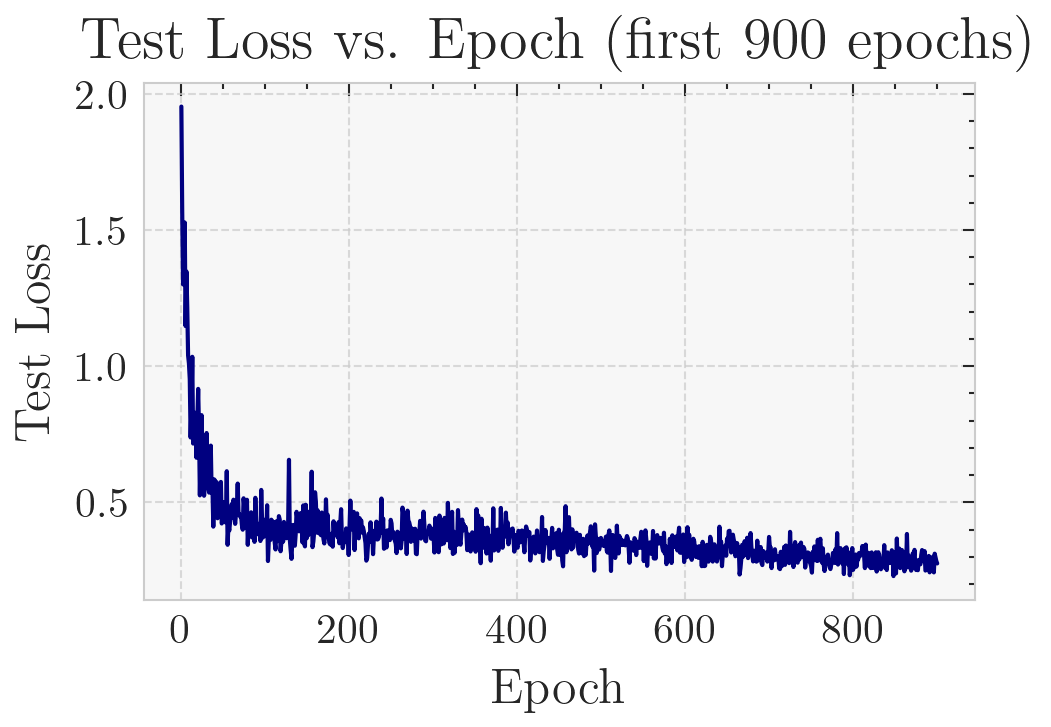

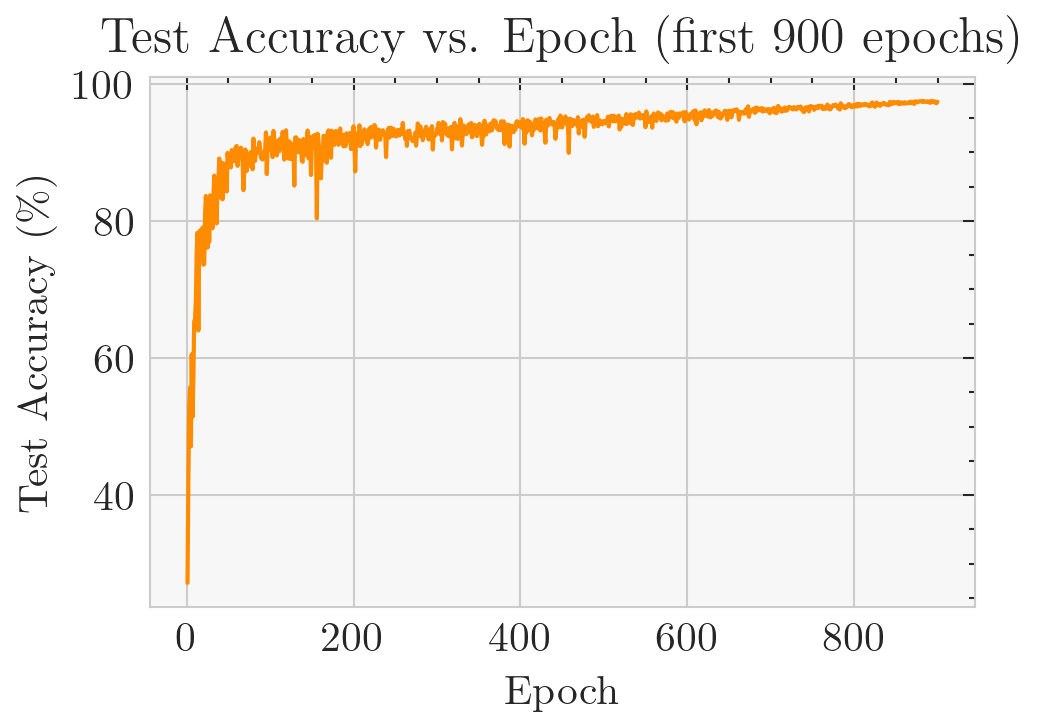

In [6]:
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import scienceplots  # Import scienceplots to register the styles

# Use SciencePlots style with high resolution
plt.style.use(['science', 'high-vis'])

# Enable LaTeX-style text rendering and Times New Roman font
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "figure.dpi": 300,                # Higher resolution
    "axes.facecolor": "#f7f7f7",      # Light grey facecolor for contrast
})

epochs = []
test_losses = []
test_accs = []
current_epoch = None
# Filter to the first 900 epochs
epoch_loss_acc = [
    (e, l, a) for (e, l, a) in zip(epochs, test_losses, test_accs)
    if e <= 900
]

epochs_900      = [x[0] for x in epoch_loss_acc]
test_losses_900 = [x[1] for x in epoch_loss_acc]
test_accs_900   = [x[2] for x in epoch_loss_acc]
# -----------------------------
#  C) PLOT TEST LOSS
# -----------------------------
fig, ax = plt.subplots()  # higher resolution
ax.plot(epochs_900, test_losses_900, linewidth=1, color='navy')

ax.set_title("Test Loss vs. Epoch (first 900 epochs)", fontsize=14)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Test Loss", fontsize=12)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()
fig.savefig('test_loss_plot.pdf', format='pdf', bbox_inches='tight')
# -----------------------------
#  D) PLOT TEST ACCURACY
# -----------------------------
fig, ax = plt.subplots()  # higher resolution
ax.plot(epochs_900, test_accs_900, linewidth=1, color='darkorange')

ax.set_title("Test Accuracy vs. Epoch (first 900 epochs)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracy (\%)")  # Corrected label to remove escape character

fig.tight_layout()
plt.show()
fig.savefig('test_accuracy_plot.pdf', format='pdf', bbox_inches='tight')


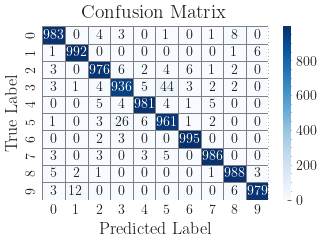

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots

train_loader, test_loader = load_cifar10_data(batch_size=1024)
model = ModifiedResNet(
        num_blocks=[4,4,3],
        base_channels=64,
        num_classes=10,
        use_se=True
    ).cuda()
# load the parameters from best_model.pth
model.load_state_dict(torch.load('best_model.pth'))
model.cuda()
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        logits = model(images)
        _, preds = logits.max(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Ensure SciencePlots style is activated
plt.style.use(['science', 'high-vis'])

# Set Times New Roman and other plotting parameters
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.facecolor": "#f9f9f9",
})

# Assuming you already have all_labels and all_preds defined:
cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots()

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, ax=ax,
            annot_kws={"size":10}, linewidths=0.5, linecolor='gray')

ax.set_title('Confusion Matrix', fontsize=14)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)

# Adjust tick label size
ax.tick_params(axis='both', which='major', labelsize=10)

fig.tight_layout()

# Save figure as PDF
fig.savefig('confusion_matrix.pdf', format='pdf', bbox_inches='tight')

plt.show()

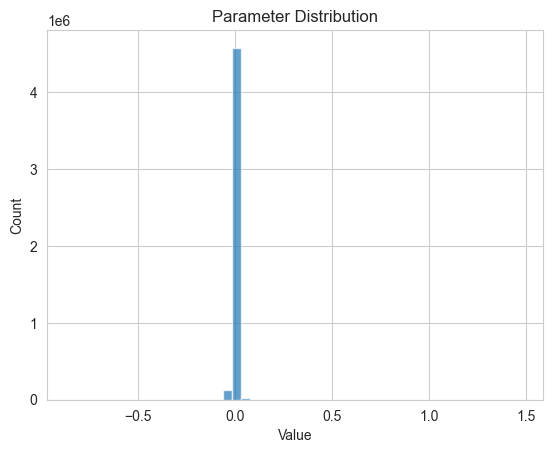

In [9]:
all_params = []
for name, param in model.named_parameters():
    if param.requires_grad:
        all_params.extend(param.detach().cpu().numpy().flatten())

plt.hist(all_params, bins=50, alpha=0.7)
plt.title('Parameter Distribution')
plt.xlabel('Value')
plt.ylabel('Count')
plt.show()